# Мастерская KPMI. Исследовательский анализ данных

## Введение

### Цель проекта

В нашем проекте две цели:
1. разработать классификатор профессий на основе ответов на вопрос "Кем ты работаешь?", 
2. построить модель, которая по результатам ответов на вопросы прогнозирует, какие сферы деятельности позволят респонденту получать удовольствие от работы.

Задача настоящего исследования: изучить данных, оценить их качество, выбрать спобы их очистки и исправления, определить необходимые преобразования для этапа разработки моделей.

Заказчик:  [KPMI](https://kpmi.ru/) - платформа по определению типа личности и подбору профессии с помощью искусственного интеллекта.

### Исходные данные

Для проекта заказчик предоставил собственные данные. 

Состав данных:
- ответы на 60 вопросов анкеты;
- ответ на вопрос "кем ты работаешь?";
- ответ на разметочный вопрос "Твоя работа позволяет тебе реализовать свои лучшие качества и способности?" (или "Тебе нравится то, чем ты занимаешься на работе?");
- время ответа в секундах на каждый вопрос;
- рассчитанный психотип;
- 4 дихотомии психотипа.

### Основные этапы

Мы исследовали данные в следующей последовательности:
- изучили структру датасета: посмотрели верхнеуровнево на размеры, типы данных, количество уникальных значений;
- исследовали качество данных: дубликаты, пропуски, выбросы и ошибки, рассмотрели способы очистки и исправления данных;
- исследовали значения признаков, их взаимосвязи.

### Выводы

- дубликаты (53) -- удалили
- пропуски в ответах (1 строка) и q61 и q62 -- много. Удалили
- пропуски в шкалах и психотипе 14000 пока оставили
- отрицательное время (75) заменили на абсолютное значение
- одинаковое время ответа в конце датасета (примерно совпадает с пропусками шкал) -- вопрос


## Подготовка кода

### Загрузка библиотек

In [81]:
import pandas as pd
import numpy as np
import random

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [76]:
import re
from sklearn.decomposition import IncrementalPCA
from sklearn.manifold import TSNE 

In [50]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/dkharitonov/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [69]:
from gensim.models import Word2Vec

In [3]:
random_state = np.random.RandomState(20220707)

### Функции

#### filter_data

In [4]:
def filter_data(prefix: str, data: list) -> list:
    '''Фильтрует массив строк data, отбирая строки, начинающиеся с prefix
    '''
    return [el for el in data if prefix == el[:len(prefix)]]

#### describe_splitted_by

In [5]:
def describe_splitted_by(step: int, data: pd.DataFrame, columns: list) -> None:
    '''Разбивает столбцы columns датасета data на порции по step столбцов и применяет к ним метод DataFrame.describe()
    '''

    for i in range(len(columns) // step + 1):
        start = i * step
        end = min(len(columns), (i + 1) * step)
        display(data[columns[start : end]].describe())

#### plot_histograms

In [6]:
def plot_histograms(
    data: pd.DataFrame, n_cols: int, bins: int, xlim: tuple, log: bool) -> None:
    '''Рисует гистограммы для каждого признака в датасете
    '''
    
    n_elements = len(data.columns)
    n_rows = np.ceil(n_elements / n_cols).astype('int')

    # Создадим фигуру
    fig, axes = plt.subplots(ncols = n_cols, 
                             nrows = n_rows, 
                             figsize = (15, n_rows * 3.5 + 2))

    # В цикле построим гистограмму для каждого признака
    for col, ax in zip(data.columns, axes.ravel()):
        ax.hist(data[col], bins = bins, log = log, edgecolor = 'black')
        ax.title.set_text(col)
        ax.set_xlim(xlim)

#### plot_boxpolts

In [7]:
def plot_boxpolts(partition: int, data: pd.DataFrame, columns: list, ylim: tuple, ylabel: str) -> None:
    '''Рисует боксплоты для всех столбцов columns в датасете data по partition на одном графике
    '''

    n_rows = np.ceil(len(columns) / partition).astype('int')
    
    # Создадим фигуру
    fig, axes = plt.subplots(ncols = 1, 
                             nrows = n_rows, 
                             figsize = (15, n_rows * 3.5 + 2))

    
    for i in range(n_rows):
        start = i * partition
        end = min(len(columns), (i + 1) * partition)
        
        data.boxplot(column=columns[start : end], ax=axes[i])
        axes[i].set_ylim(ylim)
        axes[i].set_ylabel(ylabel)

#### clean_sentence

In [63]:
def clean_sentence(val: str) -> str:
    '''Очищает строку
    
    Удаляет из строки символы, не являющиеся буквами или цифрами, переводит текст в нижний регситр, удалаяет стоп-слова
    '''
    
    regex = re.compile('([^\s\w]|_)+')
    sentence = regex.sub('', val.strip()).lower()
    sentence = sentence.split(' ')
    
    for word in list(sentence):
        if word in STOP_WORDS:
            sentence.remove(word)  
            
    sentence = ' '.join(sentence)
    return sentence

#### build_corpus

In [65]:
def build_corpus(data: pd.Series) -> list:
    '''Преобразует строку в список слов 
    '''

    corpus = []
    for sentence in data.iteritems():
        word_list = sentence[1].split(' ')
        corpus.append(word_list)
            
    return corpus

#### reduce_dimensions

In [117]:
def reduce_dimensions(model: Word2Vec) -> tuple:
    num_dimensions = 2  # final num dimensions (2D, 3D, etc)

    # extract the words & their vectors, as numpy arrays
    vectors = np.asarray(model.wv.vectors)
    labels = np.asarray(model.wv.index_to_key)  # fixed-width numpy strings

    # reduce using t-SNE
    tsne = TSNE(perplexity=40, 
                n_components=num_dimensions, 
                init='pca',  
                random_state=random_state)
    
    vectors = tsne.fit_transform(vectors)

    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]
    return x_vals, y_vals, labels

#### plot_words

In [103]:
def plot_words(x_vals: list, y_vals: list, labels: np.array, n_labels: int) -> None:
    import random

    random.seed(0)

    plt.scatter(x_vals, y_vals, alpha = .3, marker='x')

    #
    # Label randomly subsampled n_labels data points
    #
    indices = list(range(len(labels)))
    selected_indices = random.sample(indices, n_labels)
    for i in selected_indices:
        plt.annotate(labels[i], (x_vals[i], y_vals[i]))

## Загрузка данных

In [8]:
df = pd.read_csv('../datasets/raw/kpmi.ru_190k.csv', dtype={'psychotype': str})

### Описание данных

На основе анализа сайта [kpmi.ru](https://kpmi.ru/) с опросником, а также из интевью с заказчиком, нам известно о структуре данных следюющее:
- столбцы с названиями ```q1```–```q60``` содержат ответы на вопросы анкеты, посвященные определению психотипа. Принимают значения 1 или 2;
- столбцы с названиями ```t1```–```t60``` содержат время ответа на вопрос в секундах;
- столбец ```q61``` содержит ответ на впорос "кем ты работаешь?" в свободном формате, столбец ```t61``` время ответа в секундах;
- столбец ```q62``` содержит ответ на впорос "Твоя работа позволяет тебе реализовать свои лучшие качества и способности?", значения ```1 — "да"```, ```2 — "нет"```, ```3 — "затрудняюсь ответить"```; столбец ```t62``` время ответа в секундах;
- столбцы ```scale_e```, ```scale_i```, ```scale_f```, ```scale_t```, ```scale_s```, ```scale_n```, ```scale_j```, ```scale_p``` содержат 4 дихотомии типа: пары e-i, s-n, f-t, j-p;
- столбец ```psychotype``` содержит психотип респондента, полученный в результате обработки анкет.

## Анализ данных

Посмотрим в целом на размер и структуру данных.

In [9]:
df.shape

(194568, 133)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194568 entries, 0 to 194567
Columns: 133 entries, q1 to psychotype
dtypes: float64(130), int64(1), object(2)
memory usage: 197.4+ MB


В наших данных 194 568 строк и 133 столбца. Большинство столбцов — 130 — вещественного типа, 1 целочисленный и 2 строковых.

Изучим столбцы датасета.

In [11]:
all_columns = df.columns.to_list()
', '.join(all_columns)

'q1, t1, q2, t2, q3, t3, q4, t4, q5, t5, q6, t6, q7, t7, q8, t8, q9, t9, q10, t10, q11, t11, q12, t12, q13, t13, q14, t14, q15, t15, q16, t16, q17, t17, q18, t18, q19, t19, q20, t20, q21, t21, q22, t22, q23, t23, q24, t24, q25, t25, q26, t26, q27, t27, q28, t28, q29, t29, q30, t30, q31, t31, q32, t32, q33, t33, q34, t34, q35, t35, q36, t36, q37, t37, q38, t38, q39, t39, q40, t40, q41, t41, q42, t42, q43, t43, q44, t44, q45, t45, q46, t46, q47, t47, q48, t48, q49, t49, q50, t50, q51, t51, q52, t52, q53, t53, q54, t54, q55, t55, q56, t56, q57, t57, q58, t58, q59, t59, q60, t60, q61, t61, q62, t62, scale_e, scale_i, scale_f, scale_t, scale_s, scale_n, scale_j, scale_p, psychotype'

Мы видим, что все столбцы соответствуют [описанию данных](#Описание-данных). 

### Группировка столбцов

В нашем датасете 133 столбца. Такое количество неудобно анализировать. Разобьем столбцы на группы по их назанчению:
- ответы на вопросы -- столбцы начинаются с 'q',
- время ответа на вопросы -- столбцы начинаются с 't',
- шкалы -- столбцы начинаются с scale
- психотип.

In [12]:
questions, times, scales = [filter_data(prefix, all_columns) for prefix in ['q', 't', 'scale']]
psychotype = [all_columns[-1]]

(len(questions) + len(times) + len(scales) + len(psychotype)) == len(all_columns)

True

Сумма колчиества столбцов в выделенных группах равна размеру общему количеству столбцов в датасете. Следовательно мы ничего не пропустили.

Мы знаем, что вопросы организованы в группу из 60 вопросов для идентификации психотипа и два вопроса для связи с профессией. Разделим вопросы и время ответов на соответствующие группы: первые 60 -- пстихотип, последние 2 -- профессия.

In [13]:
occupation_questions = questions[-2:]
occupation_times = times[-2:]
psychotype_questions = questions[:-2]
psychotype_times = times[:-2]

In [14]:
occupation_questions, occupation_times

(['q61', 'q62'], ['t61', 't62'])

#### Вывод

Мы разбили названия столбцов на смысловые группы и сохранили списки названий в соответствующих переменных. Эти переменные мы сможем применить для выделения нужных для анализа данных.

### Структура данных

Построим график количества уникальных значений в каждом столбце. Он позволит нам увидеть бинарные, дискретные и непрерывные признаки.

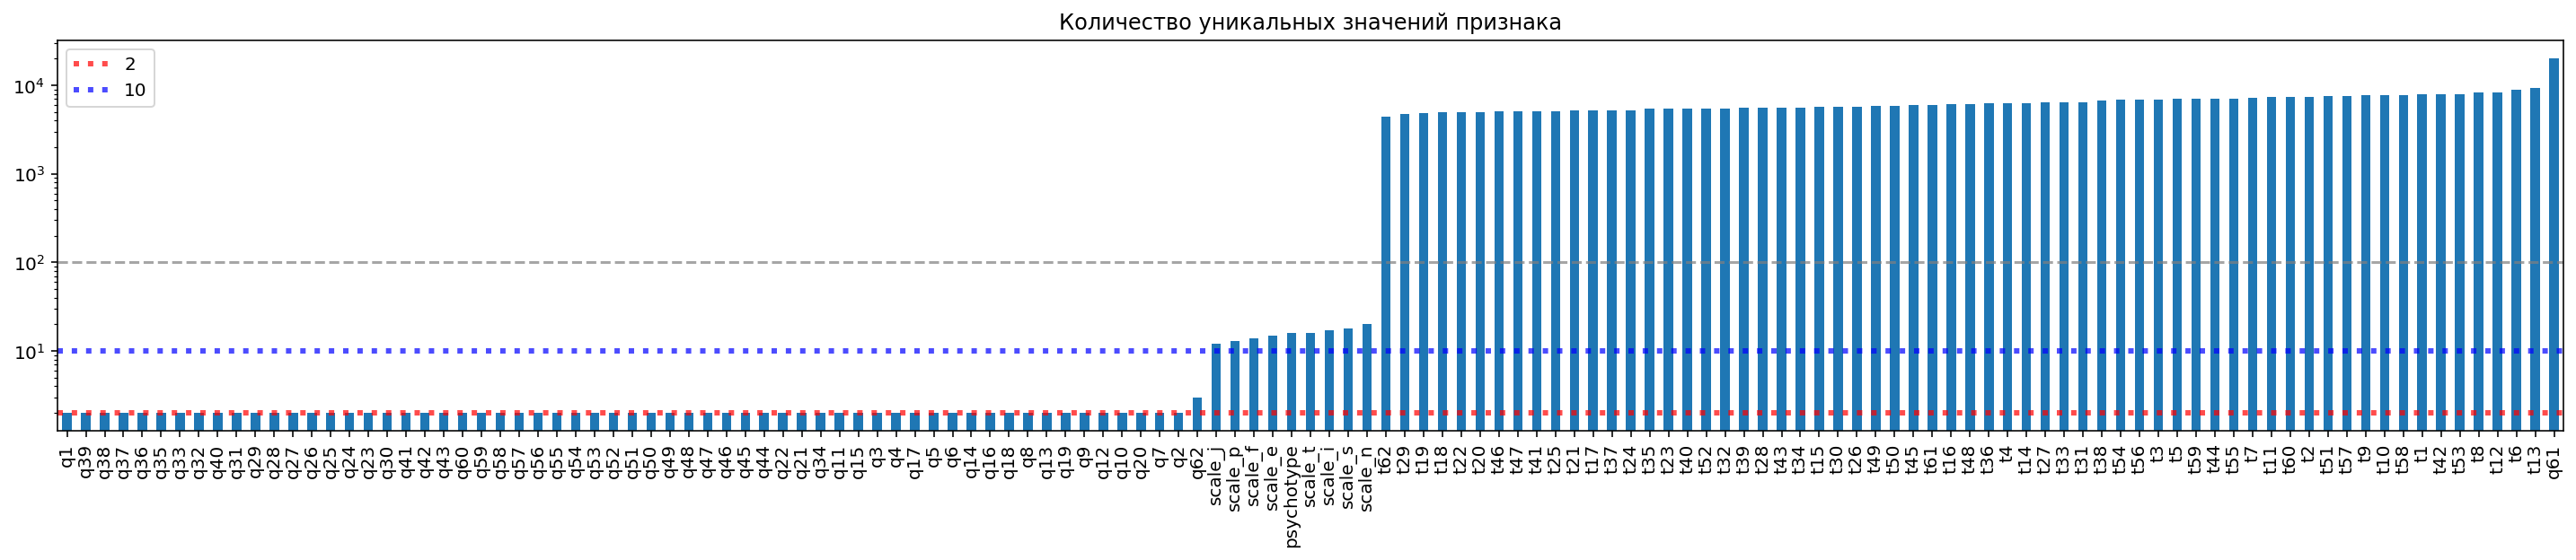

In [15]:
# для каждого столбца посчитаем количество уникальных значений и отсортируем
unique_values =  df.nunique().sort_values()

# Построим график с логарифимческой шкалой
unique_values.plot.bar(
    logy = True, figsize = (25, 4),
    title = 'Количество уникальных значений признака'
);

# добивим горизонтальные линии для значений 2 и 10, чтобы визуализировать бинарные и 
# дискретные признаки 
plt.axhline(2, color='red', lw = 3, alpha=0.7, linestyle='dotted')
plt.axhline(10, color='blue', lw = 3, alpha=0.7, linestyle='dotted')

# добавим линию сетки для значения 100
plt.axhline(100, color='gray', alpha=0.7, linestyle='dashed')


plt.legend([2, 10])
plt.show()

Мы видим, что ответы на вопросы анкеты ```q1```–```q60``` действительно являются бинарными, то есть содержат только два уникальных значения.

Ответы на вопрос ```q62``` представлены 3 уникальными значениями, что также соответствует описанию.

Столбцы ```scale_e``` — ```scale_n``` содержат от 10 до 20 значений, являются дискретными.

Столбец ```psychotype``` содрежит 16 значений, что соответсвует описанию, является категориальным.

Столбцы со временем ответа на вопросы ```t1```—```t62``` содержат около 5 тысяч уничкальных значений, являются непрерывными.

Больше всего уникальных значений имеет столбец ```q61``` с ответами на вопрос "кем ты работаешь?". В нашем датасете более 20 тысяч вариантов ответа на этот вопрос. Нашей задачей будет разработка алгоритма приведения ответа в свободной форме к выбору значения профессии из множества существенно меньшего размера. Этот признак относится к категориальным.

#### Категориальные признаки

Исследуем структуру категориальных признаков.

In [16]:
df.describe(exclude='number')

,q61,psychotype
count,152856,172164
unique,20337,16
top,Никем,ISTJ
freq,9086,27763


In [17]:
df.select_dtypes(object).sample(5, random_state = random_state)

,q61,psychotype
24076,Ученик,INTJ
160064,Никем,INTJ
107544,никем,ISFJ
15904,NaN,ESTJ
15627,Учусь,ISFJ


**ВЫВОД**

Мы видим, что в столбцах есть пропуски. 

В ответах на вопрос о роде деятельности 20 337 уникальных значений, чаще всего, 9 тыс раз, встречается значение "Никием".

Уникальных психотипов 16, что ожидаемо: 4 шкалы по 2 значения дают $2^4 = 16$ комбинаций. 

Самый часто встречающийся психотип ISTJ -- почти 28 тыс раз. 

![Как выглядит ISTJ](https://www.verywellmind.com/thmb/0o0F3f4bG-Ts3ZQeMvhb4RniVvA=/614x0/filters:no_upscale():max_bytes(150000):strip_icc()/istj-introversion-sensing-thinking-judgment-2795992-5c2d08b446e0fb00018d5773.png)
_[Illustration by JR Bee, Verywell](https://www.verywellmind.com/istj-introversion-sensing-thinking-judgment-2795992)_

#### Числовые признаки

Изучим статистики числовых признаков.

Начнем с анализа ответов на вопросы анкеты.

In [18]:
describe_splitted_by(10, df, questions)

,q1,q2,q3,q4,q5,q6,q7,q8,q9,q10
count,194568.000000,194567.000000,194567.000000,194567.000000,194567.000000,194567.000000,194567.000000,194567.000000,194567.000000,194567.000000
mean,1.549391,1.552745,1.348610,1.382819,1.471755,1.672015,1.373013,1.575971,1.595630,1.549548
std,0.497556,0.497211,0.476531,0.486076,0.499203,0.469480,0.483607,0.494196,0.490771,0.497540
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
50%,2.000000,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,2.000000,2.000000
75%,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
max,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000


,q11,q12,q13,q14,q15,q16,q17,q18,q19,q20
count,194567.000000,194567.000000,194567.000000,194567.000000,194567.000000,194567.000000,194567.000000,194567.000000,194567.000000,194567.000000
mean,1.812476,1.513612,1.530100,1.562351,1.303757,1.479542,1.731311,1.490124,1.366059,1.466991
std,0.390333,0.499816,0.499094,0.496098,0.459880,0.499583,0.443279,0.499904,0.481727,0.498910
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
50%,2.000000,2.000000,2.000000,2.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000
75%,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
max,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000


,q21,q22,q23,q24,q25,q26,q27,q28,q29,q30
count,194567.000000,194567.000000,194567.000000,194567.000000,194567.000000,194567.000000,194567.000000,194567.000000,194567.000000,194567.000000
mean,1.701964,1.723226,1.480636,1.547595,1.632471,1.442562,1.300395,1.361824,1.441426,1.770516
std,0.457397,0.447405,0.499626,0.497731,0.482133,0.496691,0.458431,0.480529,0.496559,0.420502
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000
50%,2.000000,2.000000,1.000000,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,2.000000
75%,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
max,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000


,q31,q32,q33,q34,q35,q36,q37,q38,q39,q40
count,194567.000000,194567.000000,194567.00000,194567.000000,194567.000000,194567.000000,194567.000000,194567.000000,194567.000000,194567.000000
mean,1.201231,1.213803,1.38321,1.524863,1.274409,1.795212,1.283054,1.641368,1.710912,1.322007
std,0.400922,0.409990,0.48617,0.499383,0.446217,0.403548,0.450484,0.479600,0.453340,0.467247
min,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1.000000,1.000000,1.00000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000
50%,1.000000,1.000000,1.00000,2.000000,1.000000,2.000000,1.000000,2.000000,2.000000,1.000000
75%,1.000000,1.000000,2.00000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
max,2.000000,2.000000,2.00000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000


,q41,q42,q43,q44,q45,q46,q47,q48,q49,q50
count,194567.000000,194567.000000,194567.000000,194567.000000,194567.000000,194567.000000,194567.000000,194567.000000,194567.000000,194567.000000
mean,1.582910,1.423376,1.686838,1.638675,1.405999,1.524483,1.493357,1.282746,1.556986,1.400936
std,0.493079,0.494095,0.463781,0.480386,0.491086,0.499402,0.499957,0.450335,0.496743,0.490089
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
50%,2.000000,1.000000,2.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000,1.000000
75%,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
max,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000


,q51,q52,q53,q54,q55,q56,q57,q58,q59,q60
count,194567.000000,194567.000000,194567.000000,194567.000000,194567.000000,194567.000000,194567.000000,194567.000000,194567.000000,194567.000000
mean,1.413827,1.360138,1.601238,1.319766,1.650912,1.370736,1.322218,1.308151,1.494488,1.387872
std,0.492519,0.480042,0.489645,0.466387,0.476683,0.483003,0.467327,0.461730,0.499971,0.487266
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
50%,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000
75%,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
max,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000


,q62
count,185189.000000
mean,2.033782
std,0.876973
min,1.000000
25%,1.000000
50%,2.000000
75%,3.000000
max,3.000000


Мы убедились, что в столбцах ```q1```–```q60``` только два уникальных значения и эти значения 1 и 2. Соотношение 1 и 2 изменяется от вопроса к вопросу, что мы видим по разным значениям медины. Количество ответов во всех этих столбцах кроме q1 на 1 меньше количества строк в датасете. q1 содержит такое же количество значений, сколько строк в датасете.

Столбец ```q62``` имеет три уникальных значения в диапазоне от 1 до 3. Проверим, что уникальные значения действительно 1, 2 и 3. Содержит 185 189 значений при количестве строк 194 568.

In [19]:
df.q62.value_counts()

3.0    74446
1.0    68190
2.0    42553
Name: q62, dtype: int64

Изучим статистики для столбцов с временем ответа на вопросы.

In [20]:
describe_splitted_by(10, df, times)

,t1,t2,t3,t4,t5,t6,t7,t8,t9,t10
count,1.945680e+05,194567.000000,1.945670e+05,194567.000000,194566.000000,1.945670e+05,194567.000000,1.945670e+05,194567.000000,1.945670e+05
mean,5.607079e+01,21.275059,3.076964e+01,14.441525,14.014786,3.510847e+01,18.764205,4.177171e+01,28.593607,3.711933e+01
std,5.436131e+03,1186.044698,5.922551e+03,665.664792,510.826242,2.625322e+03,987.694108,5.353557e+03,2181.449850,4.447033e+03
min,-3.443360e+03,-13.460000,-8.790000e+01,-9.050000,-56.420000,-3.591690e+03,-341.160000,-3.055400e+02,-464.770000,6.000000e-02
25%,5.340000e+00,5.660000,6.510000e+00,5.280000,4.770000,7.680000e+00,6.500000,6.640000e+00,6.670000,7.470000e+00
50%,7.410000e+00,8.310000,8.437500e+00,7.450000,6.750000,9.370000e+00,8.437500,8.437500e+00,8.437500,8.780000e+00
75%,9.480000e+00,10.760000,1.103000e+01,9.430000,8.530000,1.458000e+01,10.960000,1.218000e+01,11.790000,1.246000e+01
max,1.714797e+06,346087.730000,2.599272e+06,238718.520000,135051.510000,1.002410e+06,253297.460000,2.180981e+06,776720.560000,1.521950e+06


,t11,t12,t13,t14,t15,t16,t17,t18,t19,t20
count,194567.000000,194567.000000,1.945670e+05,194567.000000,1.945670e+05,194567.000000,194567.000000,194567.000000,194567.000000,194566.000000
mean,23.289877,20.133837,3.956914e+01,17.817841,2.697609e+01,19.543901,8.752648,11.907196,13.101655,9.196527
std,2132.029811,629.801897,5.281149e+03,1921.010776,6.286508e+03,1530.334325,282.335338,853.324949,1783.901287,608.954013
min,-3.790000,-75.670000,-2.877000e+01,-472.000000,-5.330000e+00,-8.390000,-10.130000,0.010000,0.060000,0.020000
25%,6.050000,7.160000,7.830000e+00,5.010000,4.370000e+00,4.710000,3.770000,3.420000,3.480000,3.120000
50%,8.400000,8.580000,9.420000e+00,7.000000,6.160000e+00,6.740000,5.330000,4.880000,5.020000,4.550000
75%,10.530000,12.830000,1.404000e+01,8.650000,8.437500e+00,8.437500,8.437500,8.130000,8.340000,7.750000
max,756516.440000,130504.620000,1.901530e+06,785341.390000,2.757272e+06,572439.650000,107796.070000,248738.640000,773402.350000,257651.390000


,t21,t22,t23,t24,t25,t26,t27,t28,t29,t30
count,194567.000000,194567.000000,194567.000000,194567.000000,194567.000000,1.945670e+05,194567.000000,1.945670e+05,194567.000000,194567.000000
mean,11.451623,14.925256,12.808880,8.657048,11.605240,2.166036e+01,13.505555,1.758499e+01,6.700172,14.482513
std,744.462532,2231.872056,1274.794921,286.804729,748.322188,4.001424e+03,741.166042,3.913528e+03,85.945714,721.231296
min,-0.100000,0.060000,-54047.680000,-164.880000,-63.440000,-8.600000e+00,-3575.910000,1.000000e-02,-96.100000,-76523.800000
25%,3.450000,3.210000,3.350000,3.100000,3.310000,4.830000e+00,3.890000,3.280000e+00,2.710000,5.330000
50%,4.940000,4.650000,4.880000,4.530000,4.850000,6.500000e+00,5.440000,4.860000e+00,4.000000,7.330000
75%,8.210000,7.860000,8.260000,7.890000,8.330000,8.437500e+00,8.437500,8.420000e+00,7.070000,8.910000
max,226012.740000,859020.390000,529575.640000,71330.660000,269504.690000,1.740150e+06,190817.390000,1.724315e+06,16510.870000,181396.860000


,t31,t32,t33,t34,t35,t36,t37,t38,t39,t40
count,1.945670e+05,194567.000000,194566.000000,194567.000000,194567.000000,194567.000000,194567.000000,194567.000000,194567.000000,1.945670e+05
mean,2.303248e+01,8.864180,19.495246,16.430559,10.182456,16.915841,13.189403,16.317221,11.900601,1.713305e+01
std,3.936585e+03,160.767785,1824.773637,2234.255337,578.430813,1027.111966,887.298209,656.098530,680.603595,2.492865e+03
min,5.000000e-02,0.060000,-161.830000,-51.680000,0.050000,-3338.840000,0.070000,0.070000,0.040000,-8.300000e+00
25%,3.930000e+00,3.840000,5.580000,3.720000,3.810000,5.890000,3.770000,5.640000,4.430000,3.990000e+00
50%,5.620000e+00,5.550000,7.900000,5.360000,5.470000,8.030000,5.270000,8.180000,6.190000,5.630000e+00
75%,8.437500e+00,8.437500,9.910000,8.437500,8.437500,9.790000,8.437500,10.340000,8.437500,8.437500e+00
max,1.509478e+06,43125.440000,686747.680000,925027.920000,243457.160000,338006.210000,309284.320000,166738.970000,271121.860000,1.077338e+06


,t41,t42,t43,t44,t45,t46,t47,t48,t49,t50
count,194567.000000,194567.000000,194567.000000,194567.000000,194567.000000,194567.000000,194567.000000,194567.000000,194567.000000,194567.000000
mean,9.333561,20.929370,9.933899,18.937966,12.467400,10.690008,11.086685,11.063649,11.965574,11.082843
std,251.243887,857.126477,198.616236,1001.659983,681.184313,359.593933,532.310072,306.315381,871.813719,397.829074
min,-3.650000,-3589.500000,-144.450000,-72.210000,0.060000,-75.380000,-6.190000,-154.880000,-8.340000,-72.200000
25%,4.000000,6.960000,4.740000,6.300000,4.100000,4.670000,4.350000,4.280000,3.870000,4.320000
50%,5.470000,8.640000,6.420000,8.437500,5.790000,6.450000,6.020000,6.080000,5.500000,6.120000
75%,8.437500,13.180000,8.437500,10.690000,8.437500,8.437500,8.437500,8.437500,8.437500,8.437500
max,84554.200000,223379.020000,53981.750000,257278.850000,245700.290000,94172.970000,188392.520000,72896.020000,351721.780000,146846.610000


,t51,t52,t53,t54,t55,t56,t57,t58,t59,t60
count,194567.000000,194567.000000,1.945670e+05,194567.000000,194567.000000,1.945660e+05,194566.000000,194567.000000,194566.000000,194567.000000
mean,18.969167,13.388244,2.605003e+01,15.755147,16.320239,2.664411e+01,19.746608,17.801299,12.997785,24.522245
std,699.503299,1210.458590,4.143217e+03,1002.527823,786.906676,3.348171e+03,1132.322309,491.811164,619.458166,2744.623313
min,0.030000,0.020000,-5.188000e+01,0.030000,0.030000,-1.638900e+02,-8.300000,-66.730000,0.060000,0.030000
25%,6.760000,3.880000,7.010000e+00,5.520000,6.600000,6.090000e+00,7.430000,6.820000,5.350000,7.090000
50%,8.437500,5.450000,8.437500e+00,7.740000,8.437500,8.437500e+00,8.990000,8.437500,7.370000,8.437500
75%,12.110000,8.437500,1.215000e+01,9.730000,11.660000,1.057000e+01,13.450000,12.060000,9.110000,12.130000
max,201468.260000,510288.800000,1.811677e+06,393343.060000,322278.610000,1.262039e+06,406887.410000,100394.450000,256737.920000,939268.140000


,t61,t62
count,188316.000000,185189.000000
mean,16.710691,11.474681
std,1552.652014,904.491933
min,-5.700000,-6.000000
25%,6.700000,4.330000
50%,8.437500,5.980000
75%,12.540000,8.437500
max,623374.000000,347842.020000


Мы видим, что количество значений в столбцах t1-t62 практически равно количеству значений в столбцах q1-q62. Есть разница на 1 одну запись для, например, t5, t33, t56 — 194 566 значение при 194 567 в q5, q33, q56. При таком количестве строк разница в 1 значение не выглядит сущетсвенной.

Миниальное значение времени во многих столбцах имеет отрицательные значения. От заказчика мы знаем, что была ошибка в данных. Предположим, что отрицательные значения были получены из-за того, что перепутали начало и конец интервала.

Изучим статистики шкал.

In [21]:
describe_splitted_by(10, df, scales)

,scale_e,scale_i,scale_f,scale_t,scale_s,scale_n,scale_j,scale_p
count,172164.000000,172164.000000,172164.000000,172164.000000,172164.000000,172164.000000,172164.000000,172164.000000
mean,13.741677,21.438326,16.881584,16.777782,16.143026,16.717333,20.897435,15.961397
std,8.152163,7.612804,7.897234,7.743296,8.501869,6.571154,7.828525,7.553124
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8.000000,15.000000,11.000000,12.000000,10.000000,12.000000,16.000000,9.000000
50%,12.000000,22.000000,16.000000,16.000000,16.000000,16.000000,22.000000,15.000000
75%,20.000000,28.000000,22.000000,23.000000,23.000000,21.000000,25.000000,20.000000
max,35.000000,35.000000,35.000000,35.000000,35.000000,37.000000,35.000000,35.000000


Данные по шкалам есть в 172 164 строках. Диапазон значений во всех столбцах одинаковый и составляет 0–35. 

Шкалы ```e```, ```i```, ```j``` имеют скошенное распределение: ```e``` — влево, ```i``` и ```j``` — вправо. 

#### Выводы

Мы видим, что структура данных соответствует описанию. 

Ответы на вопросы анекты бинарные. Значения шкал психотипов дискретные в диапазоне 0-35. Психотип является категориальным признаком.

Наибольшее разнообразие значений мы наблюдаем в ответах на вопрос "Кем ты работаешь?", который является открытым. 

### Качество данных

На этом этапе проверим наличие дубликатов и изучим пропуски в данных.

#### Дубликаты

In [22]:
n_duplicates = df.duplicated().sum()
print('Количество дубликатов:', n_duplicates)

Количество дубликатов: 53


Удалим обнаруженные дубликаты.

In [23]:
df = df.drop_duplicates()
df.shape

(194515, 133)

#### Обзор пропусков

Посмотрим на пропуски всего датасета.

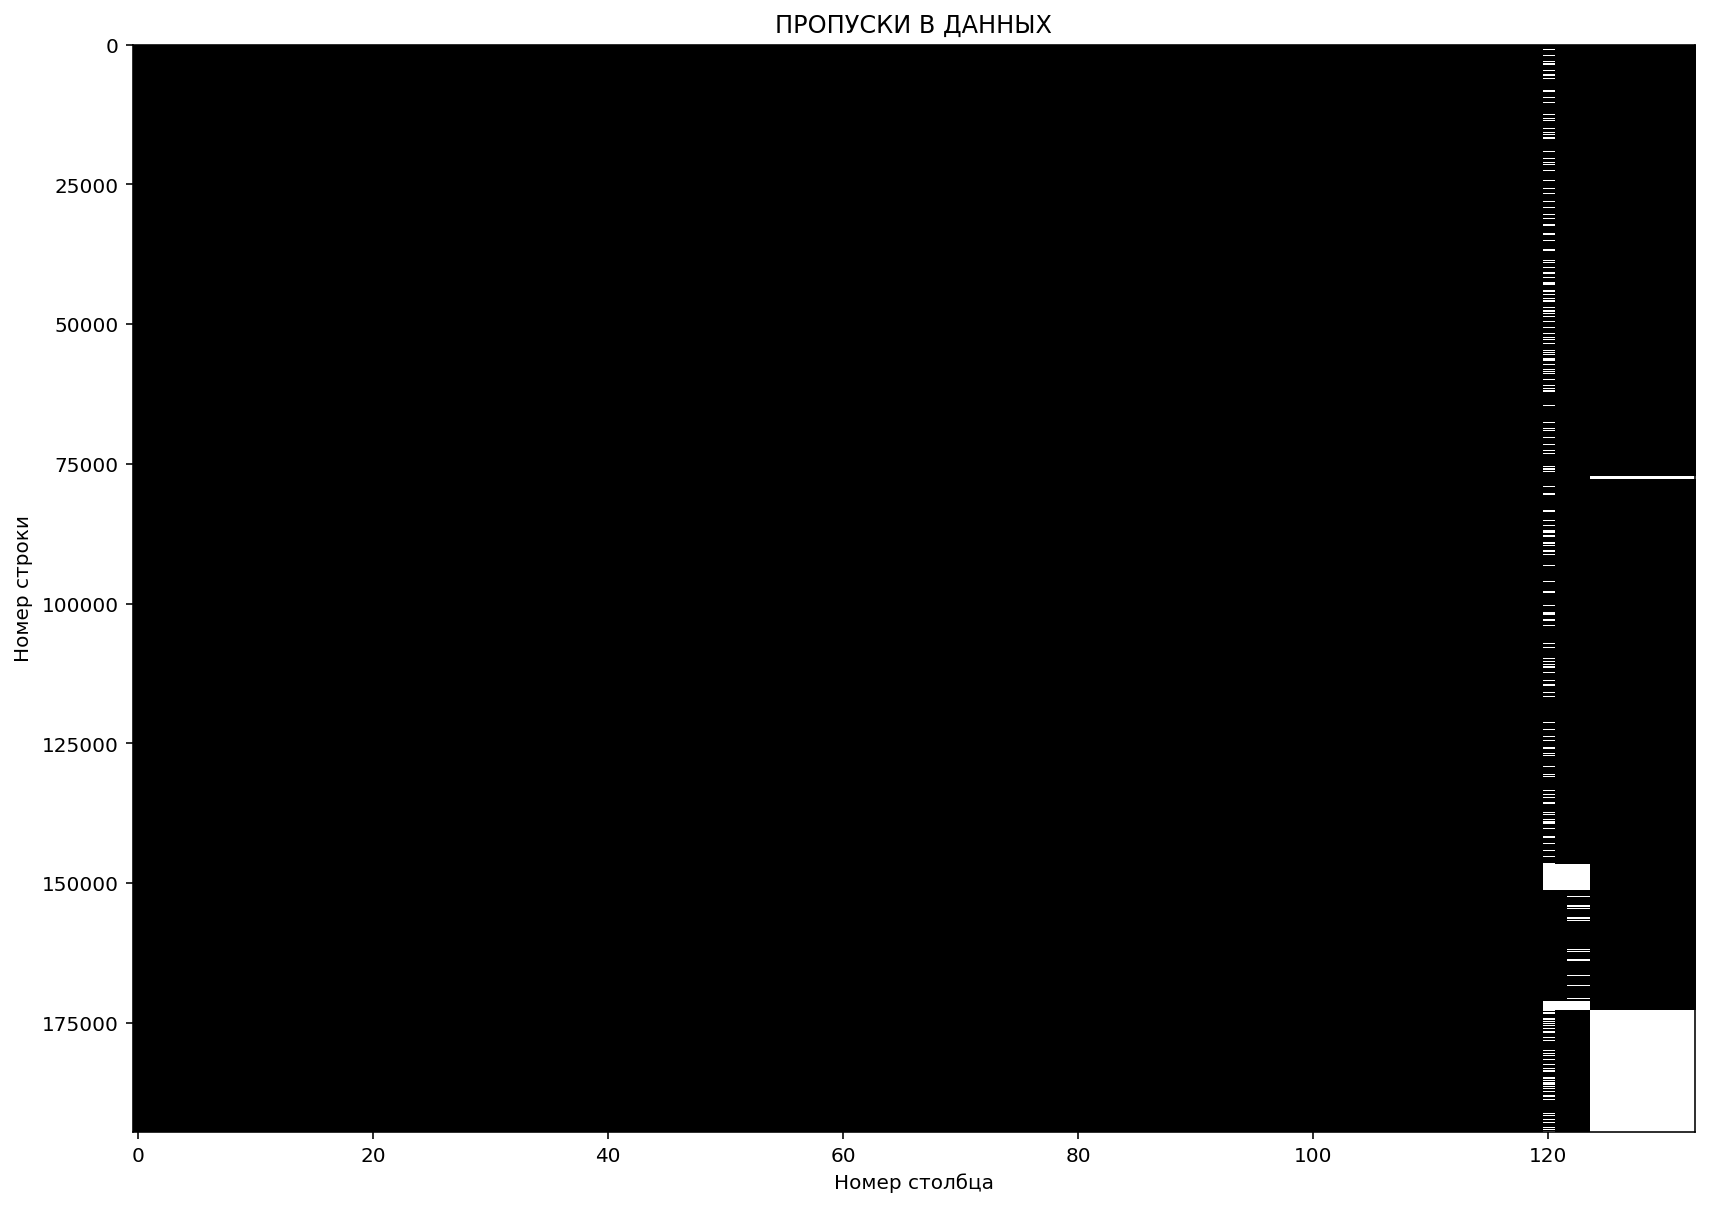

In [24]:
plt.figure(figsize=(14, 10))
plt.imshow(df.isna(), aspect='auto', interpolation='nearest', cmap='gray')
plt.title('Пропуски в данных'.upper())
plt.xlabel('Номер столбца')
plt.ylabel('Номер строки');

Ранее мы видели, что в ответах на вопросы и времени ответов пропусков почти нет, что подтверждает график.

Мы видим равномерные пропуски в 120м столбце (```q61```) по всему датасету В опроснике этот ответ не является обязательным, поэтому пропуски являются нормальным явлением.

К наблюдаемым аномалиям отнесем:
- выпадение блоков из 4х столбцов 120-123 (```q61```, ```t61```, ```q62```, ```t62```) в области 150-ти тысяч и 170-ти тысяч строк;
- пропуски в столбцах 122 и 123 (```q62```, ```t62```) в диапазоне 150–170-ти тысяч строк;
- фрагмент строк в диапазоне 150тыс - 175 тыс, где много пропусков в 121м столбце и нет пропусков в 120м столбце;
- сплошные пропуски в столбцах 124-133 начиная со 175 тыс. строки (```scale_e```, ```scale_i```, ```scale_f```, ```scale_t```, ```scale_s```, ```scale_n```, ```scale_j```, ```scale_p```, ```psychotype```).

Проблемные столбцы:

In [25]:
df.columns[120:]

Index(['q61', 't61', 'q62', 't62', 'scale_e', 'scale_i', 'scale_f', 'scale_t',
       'scale_s', 'scale_n', 'scale_j', 'scale_p', 'psychotype'],
      dtype='object')

#### Распределение количества пропусков по столбцам

Посмотрим, какая доля строк содержит пропуски по каждому отмеченному выше столбцу.

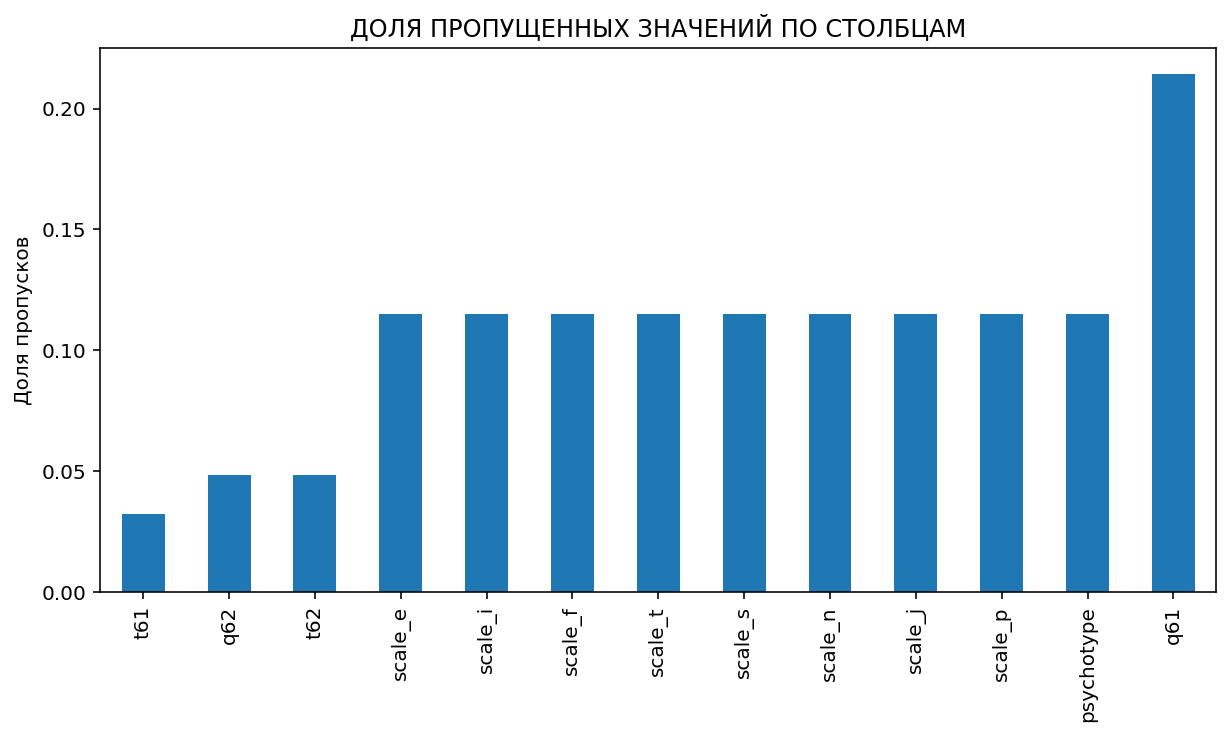

In [26]:
df.iloc[:,120:].isna().mean().sort_values().plot(
    kind='bar', figsize=(10, 5),
    title='Доля пропущенных значений по столбцам'.upper(),
    ylabel='Доля пропусков');
plt.show()

Мы видим, что ответ на вопрос "Кем ты работаешь?" пропущен приблизительно в 20% строк как результат необязательного поля в анкете. 

Примерно в 12% строк нет данных о шкалах и психотипе. При этом мы видим, что эти пропуски локализованы в конце датасета. Можно предположить, что этот период расчеты шкал и психотипа не производились, либо был сбой выгрузки этих данных в общий датасет.

5% пропусков в ответах на вопрос "Твоя работа позволяет тебе реализовать свои лучшие качества и способности" в основном также локализованы в определенном месте датасета (строки в области 150 и 170 тыс.). Можно предпложить сбой в интеграции данных в этот период.

#### Пропуски в вопросах анкеты и времени

Мы видели, что в столбцах с ответами на вопросы анкеты, кроме q1, есть по одному пропуску. Проверим, находится ли этот пропуск в одной строке, то есть для одной записи пропущены все ответы q2-q60.

In [27]:
df[psychotype_questions[1:]].isna().all(axis=1).sum()

1

Да, все пропуски находятся в одной строке.

В столбцах со временем ответов на вопросы анкеты психотипа пропусков больше. Посмотрим, сколько строк содержат пропуски времени ответа хотя бы в одном столбце.

In [28]:
df[psychotype_times[1:]].isna().any(axis=1).sum()

5

#### Выводы

Удаляем строки с пропусками в вопросах и времени ответов. 

Строки с пропусками в шкале и психотипе оставим до выбора признаков.

In [29]:
df = df.dropna(axis = 0, subset = questions + times, how = 'any').reset_index(drop=True)
df.shape

(149700, 133)

Посмотрим, сколько осталось пропусков в шкалах.

In [30]:
df[scales].isna().sum()

scale_e    14033
scale_i    14033
scale_f    14033
scale_t    14033
scale_s    14033
scale_n    14033
scale_j    14033
scale_p    14033
dtype: int64

И сохраним промежуточный датасет.

In [31]:
df.to_csv('../datasets/intermediate/df_duplicates_isna_processed.csv')

### Ошибки в значениях

#### Числовые признаки

Проверим наш датасет на проблемы с заполнением числовых значений. 

Для каждого числового признака построим график, который визуализирует значения признака (ось Y) для каждого из объектов в датасете (ось X).

Мы ожидаем, что распределение значений будет охватывать весь диапазон по оси Y для всех объектов, то есть на всем протяжении оси X. Пробелы по оси X покажут ошибки заполнения значений.

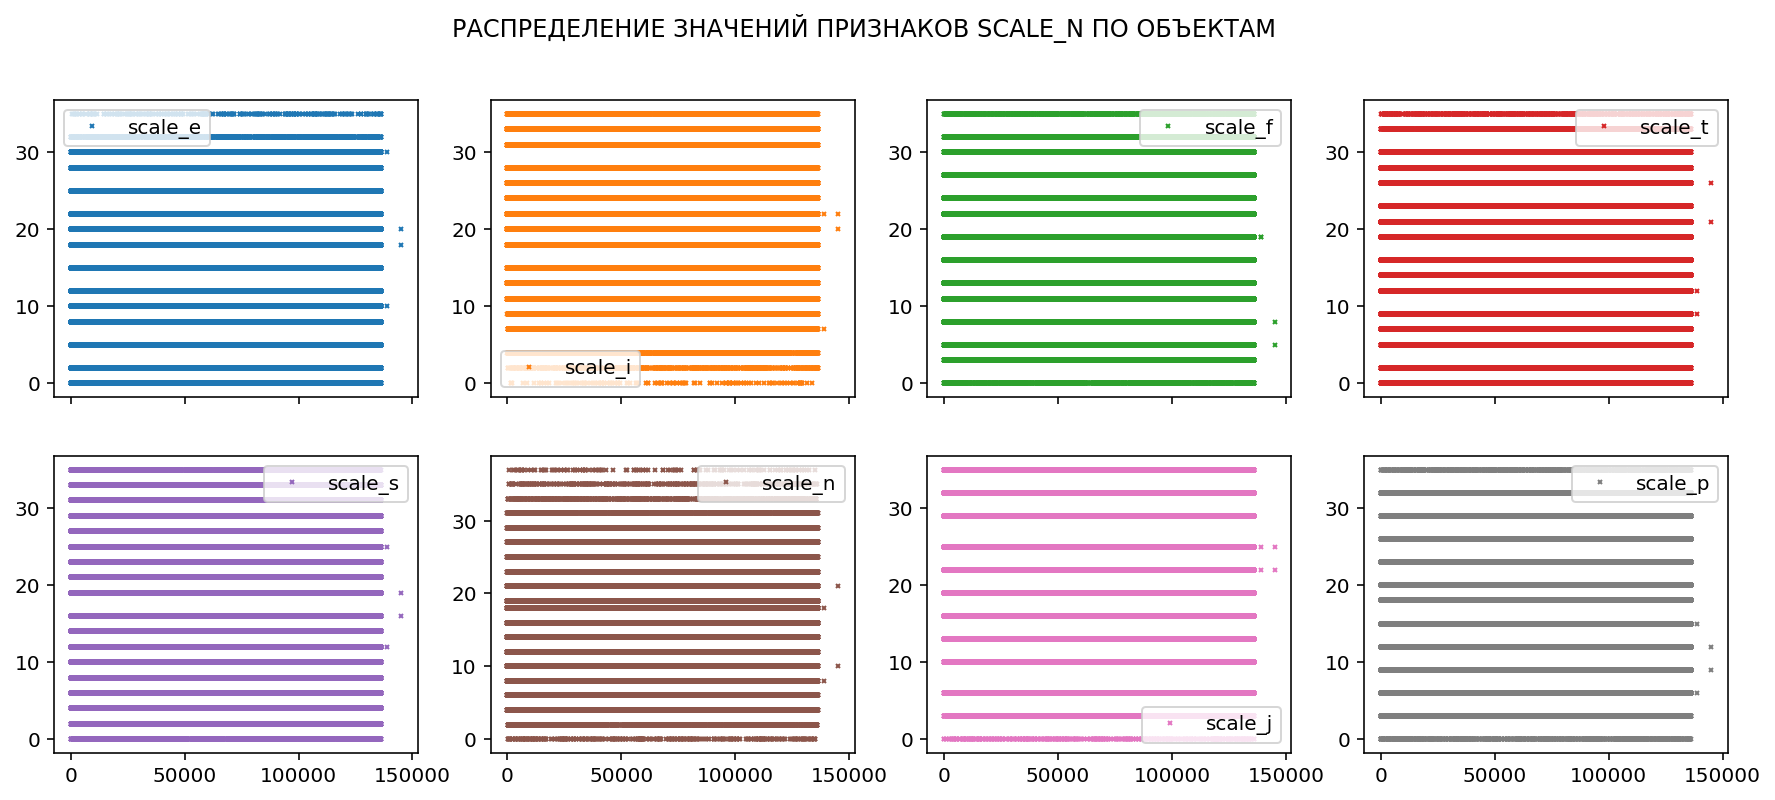

In [32]:
df[scales].plot(
    lw=0, marker="x", subplots=True, layout=(-1, 4),
    figsize=(15, 6), markersize=2,
    title = 'Распределение значений признаков scale_n по объектам'.upper()
)

plt.show()

Видим однородное распределение значений по объектам, нет горизонтальных участков с одним значением. Есть пропуск в конце диапазона, что совпдает с картиной, которую мы наблюдали при анализе пропущенных значений.

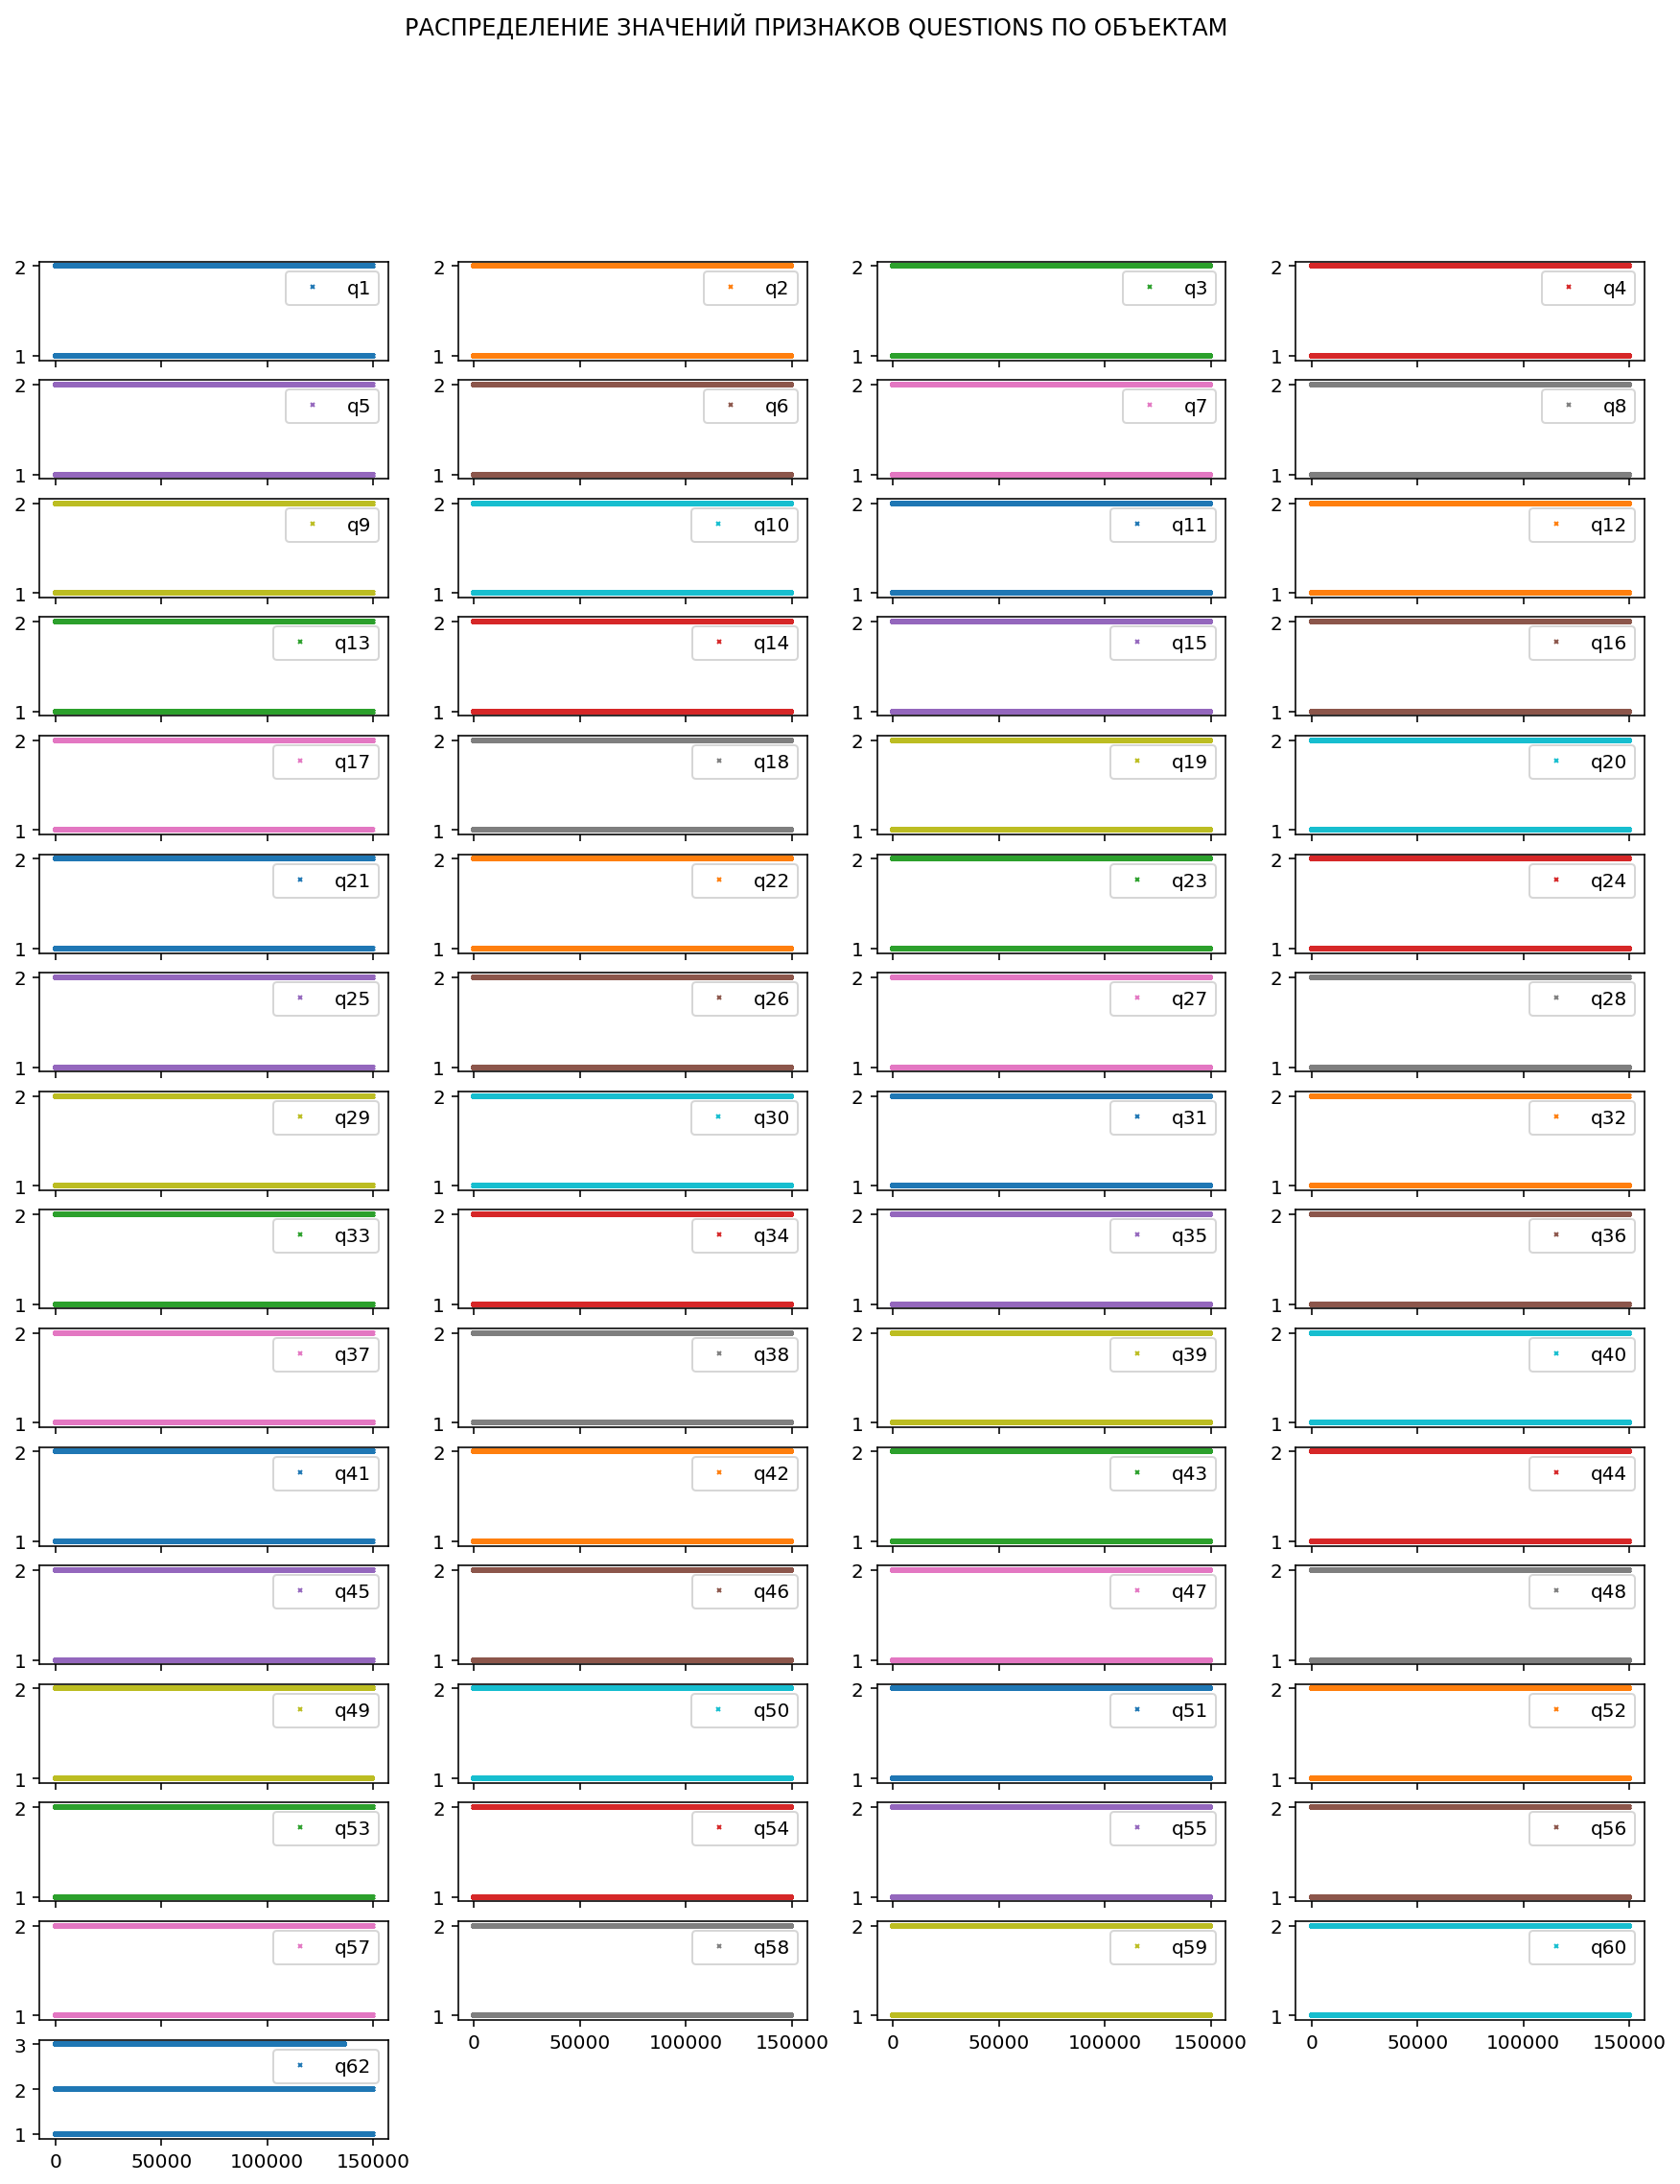

In [33]:
df[questions].select_dtypes(include='number').plot(
    lw=0, marker="x", subplots=True, layout=(-1, 4),
    figsize=(15, 18), markersize=2,
    title = 'Распределение значений признаков questions по объектам'.upper()
)

plt.show()

Ответы на впоросы распределены по всем объектам однородно. Нет участков с одним значением (одна горизонтальная прямая). Тут все хорошо.

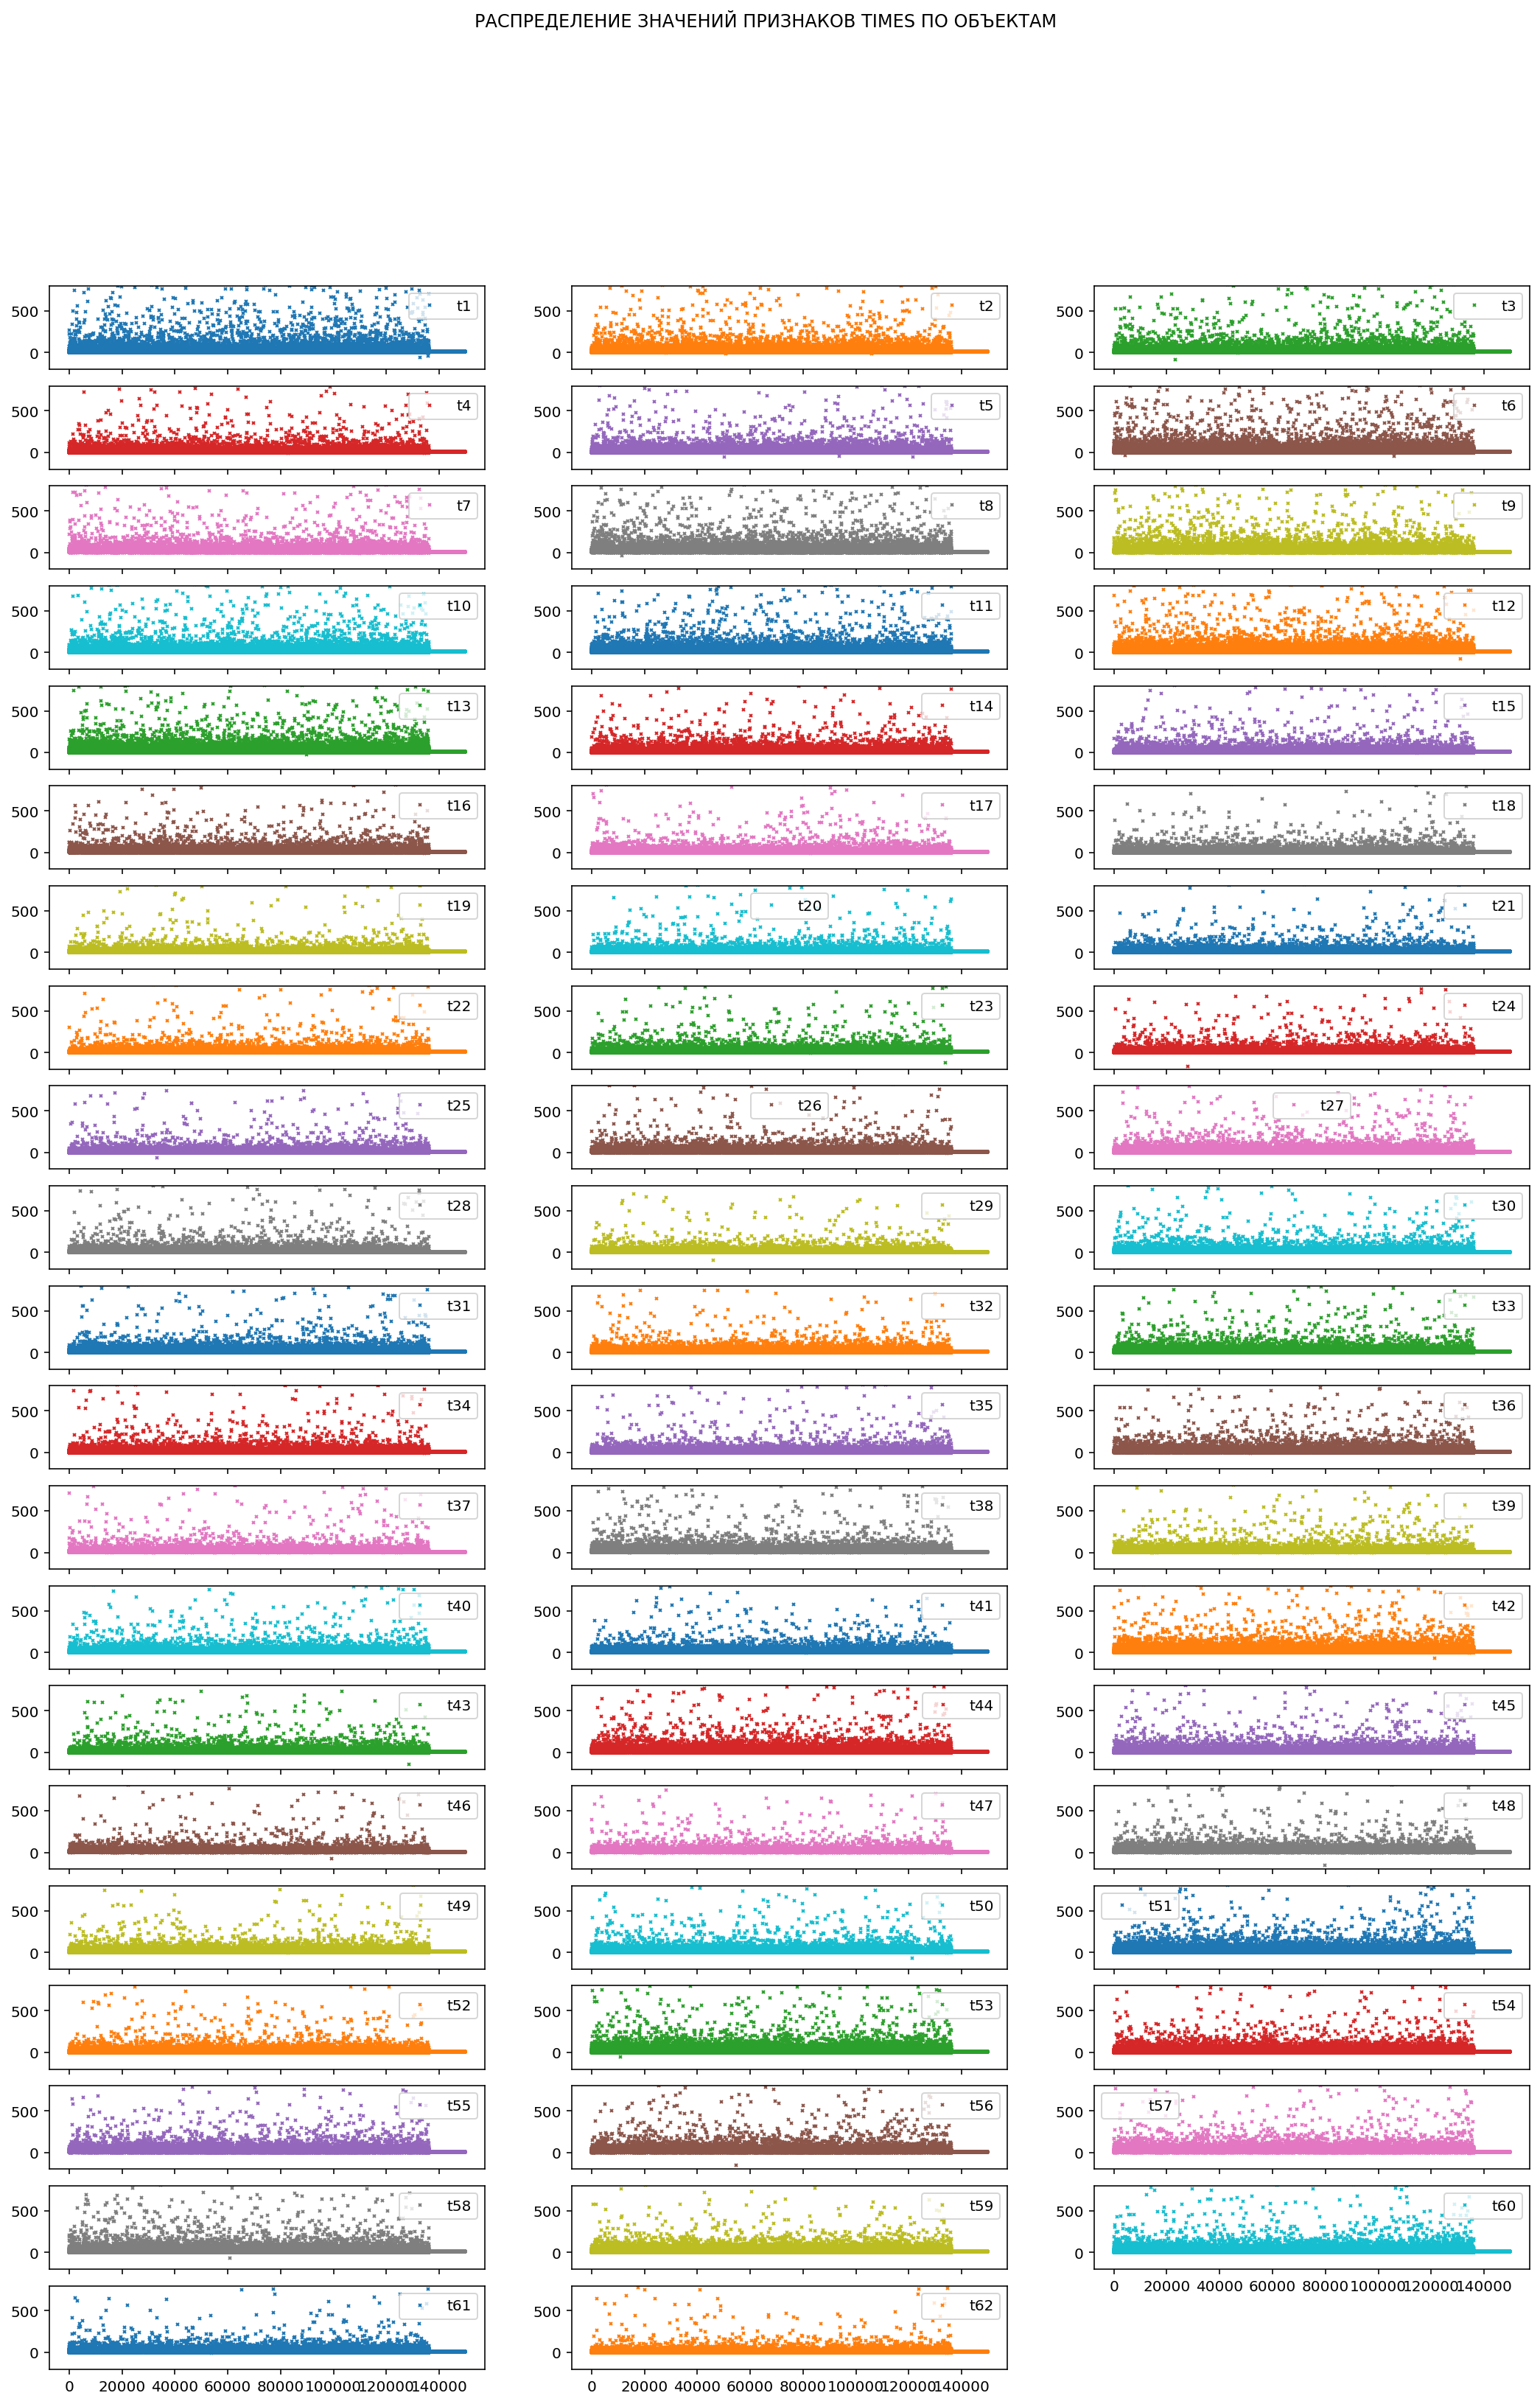

In [34]:
df[times].plot(
    lw=0, marker="x", subplots=True, layout=(-1, 3), ylim=(-200, 800),
    figsize=(18, 26), markersize=2,
    title = 'Распределение значений признаков times по объектам'.upper()
)

plt.show()

Мы видим, что примерно до 135 тыс. строчки характер распределения значений однородый: плотная область в диапазоне 0-100 секунд, потом выбросы. 

В конце датасета, примерно со 135 тыс. строки мы видим, что время во всех столбцах преврящается в прямую вдоль горизонтальной оси. Это аномалия, совпадающая с пропусками значений в шкалах.

In [35]:
df[times[:15]].iloc[136204:136215]

,t1,t2,t3,t4,t5,t6,t7,t8,t9,t10,t11,t12,t13,t14,t15
136204,17.3000,5.9500,8.9600,23.7400,6.1300,43.1400,8.3000,136.3100,29.4900,28.0800,493.5800,20.1800,12.4900,6.3900,10.9700
136205,1.1900,0.4400,0.3300,0.3100,0.3000,0.2800,0.2600,0.2900,0.3100,0.2200,0.2800,0.3000,0.2400,0.2800,0.2700
136206,8.4375,8.4375,8.4375,8.4375,8.4375,8.4375,8.4375,8.4375,8.4375,8.4375,8.4375,8.4375,8.4375,8.4375,8.4375
136207,8.4375,8.4375,8.4375,8.4375,8.4375,8.4375,8.4375,8.4375,8.4375,8.4375,8.4375,8.4375,8.4375,8.4375,8.4375
136208,8.4375,8.4375,8.4375,8.4375,8.4375,8.4375,8.4375,8.4375,8.4375,8.4375,8.4375,8.4375,8.4375,8.4375,8.4375
136209,8.4375,8.4375,8.4375,8.4375,8.4375,8.4375,8.4375,8.4375,8.4375,8.4375,8.4375,8.4375,8.4375,8.4375,8.4375
136210,8.4375,8.4375,8.4375,8.4375,8.4375,8.4375,8.4375,8.4375,8.4375,8.4375,8.4375,8.4375,8.4375,8.4375,8.4375
136211,8.4375,8.4375,8.4375,8.4375,8.4375,8.4375,8.4375,8.4375,8.4375,8.4375,8.4375,8.4375,8.4375,8.4375,8.4375
136212,8.4375,8.4375,8.4375,8.4375,8.4375,8.4375,8.4375,8.4375,8.4375,8.4375,8.4375,8.4375,8.4375,8.4375,8.4375
136213,8.4375,8.4375,8.4375,8.4375,8.4375,8.4375,8.4375,8.4375,8.4375,8.4375,8.4375,8.4375,8.4375,8.4375,8.4375


In [36]:
df[times[:15]].tail()

,t1,t2,t3,t4,t5,t6,t7,t8,t9,t10,t11,t12,t13,t14,t15
149695,8.4375,8.4375,8.4375,8.4375,8.4375,8.4375,8.4375,8.4375,8.4375,8.4375,8.4375,8.4375,8.4375,8.4375,8.4375
149696,8.4375,8.4375,8.4375,8.4375,8.4375,8.4375,8.4375,8.4375,8.4375,8.4375,8.4375,8.4375,8.4375,8.4375,8.4375
149697,8.4375,8.4375,8.4375,8.4375,8.4375,8.4375,8.4375,8.4375,8.4375,8.4375,8.4375,8.4375,8.4375,8.4375,8.4375
149698,8.4375,8.4375,8.4375,8.4375,8.4375,8.4375,8.4375,8.4375,8.4375,8.4375,8.4375,8.4375,8.4375,8.4375,8.4375
149699,8.4375,8.4375,8.4375,8.4375,8.4375,8.4375,8.4375,8.4375,8.4375,8.4375,8.4375,8.4375,8.4375,8.4375,8.4375


Действительно, со строки номер 136206 значение времени у всех признаков одинаковое и равно 8.4375

Отметим, что отрицательные значения времени на графике не заметны. Проверим, сколько в наборе данынх отрицательных значений у времени ответов.

In [37]:
df[times][df[times] < 0].count().sum()

75

Отрицательных значений действительно мало. Предполодим, что ошибка связана с вычитанием времени окончания из времени начала. Заменим отрицательные значения их абослютным значением.

In [38]:
df[times] = abs(df[times])

In [39]:
df[times][df[times] < 0].count().sum()

0

Отрицательных значений нет

#### Категориальные признаки

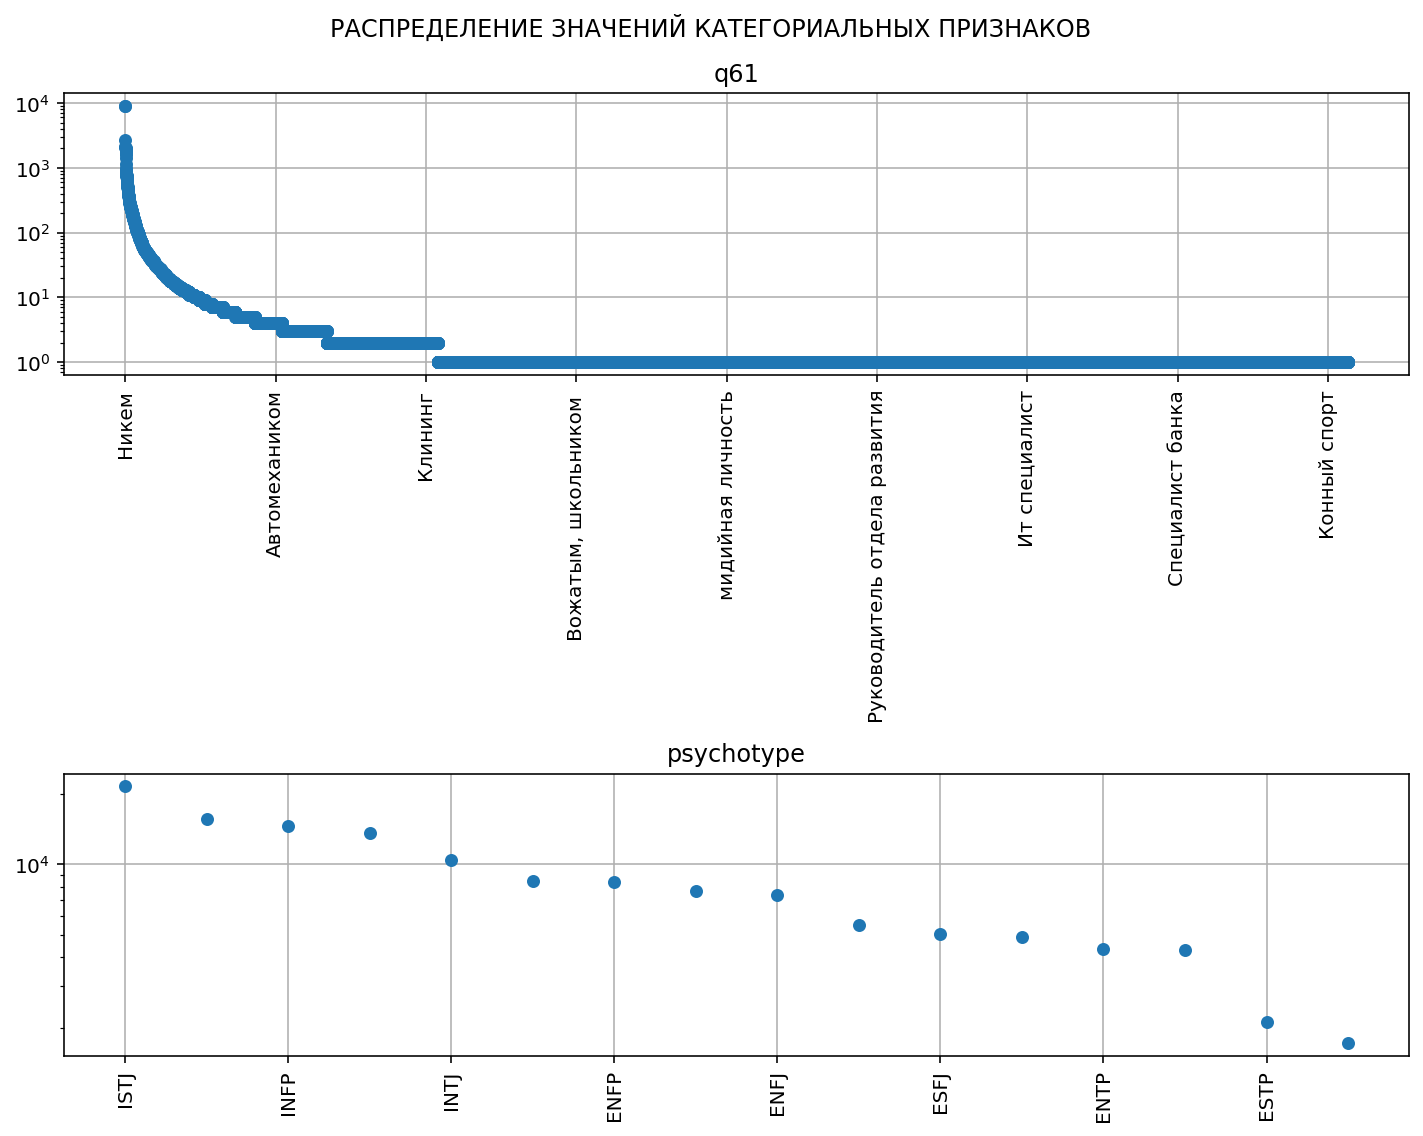

In [40]:
# Выделим категориальные признаки 
df_categorical = df.select_dtypes(exclude = 'number')

# Создадим фигуру с количеством графиков, равных еоличеству столбцов 
fig, axes = plt.subplots(ncols = 1, nrows= df_categorical.shape[1], figsize = (10, 8))

# Добавим в цикле график для каждого признака на соответсвующей оси
for col, ax in zip(df_categorical.columns, axes.ravel()):

    # Посчитаем количество уникальных значений признака
    df_categorical[col].value_counts().plot(

        # Отобразим на графике в логарифмической шкале
        logy = True, title = col, lw = 0, marker='.', rot = 90,
        ax = ax, markersize = 11, grid = True)

plt.suptitle('Распределение значений категориальных признаков'.upper())
plt.tight_layout();
plt.show()

Ответы на вопросы "Кем ты работаешь?" можно разделить на три группы: очень часто встречающиеся ответы, когда значение встречается более 50 раз, частые -- встречающиеся от 2 до 50 раз, и редкие -- встречаются по 1 разу.

Мы уже видели, что значение "Никем" встречается чаще всего. Тут мы видим, что так отвечают с большим отрывом от других вариантов ответа. Отметим, что наблюдаемый характер распределения значений ожидаем от открытого вопроса.

На графике ```psychotype``` мы также видим неравномерное распределение значений. Частота появления лидеров в левой части графика на порядок больше чем аутсайдеров справа. 

Это означает, что при разработке моделей у нас будет существенно разное количество данных по каждому психотипу.

#### Выводы

Мы рассмотрели характер распределения значений признаков по объектам в датасете. В результате анализа обнаружили, что значения всех признаков времени ответа на вопросы (t1-t62) в конце датасета принимют одинаковые значения 8.4375.

### Характер данных

Изучим характер распределения значений признаков.

#### Ответы на вопросы

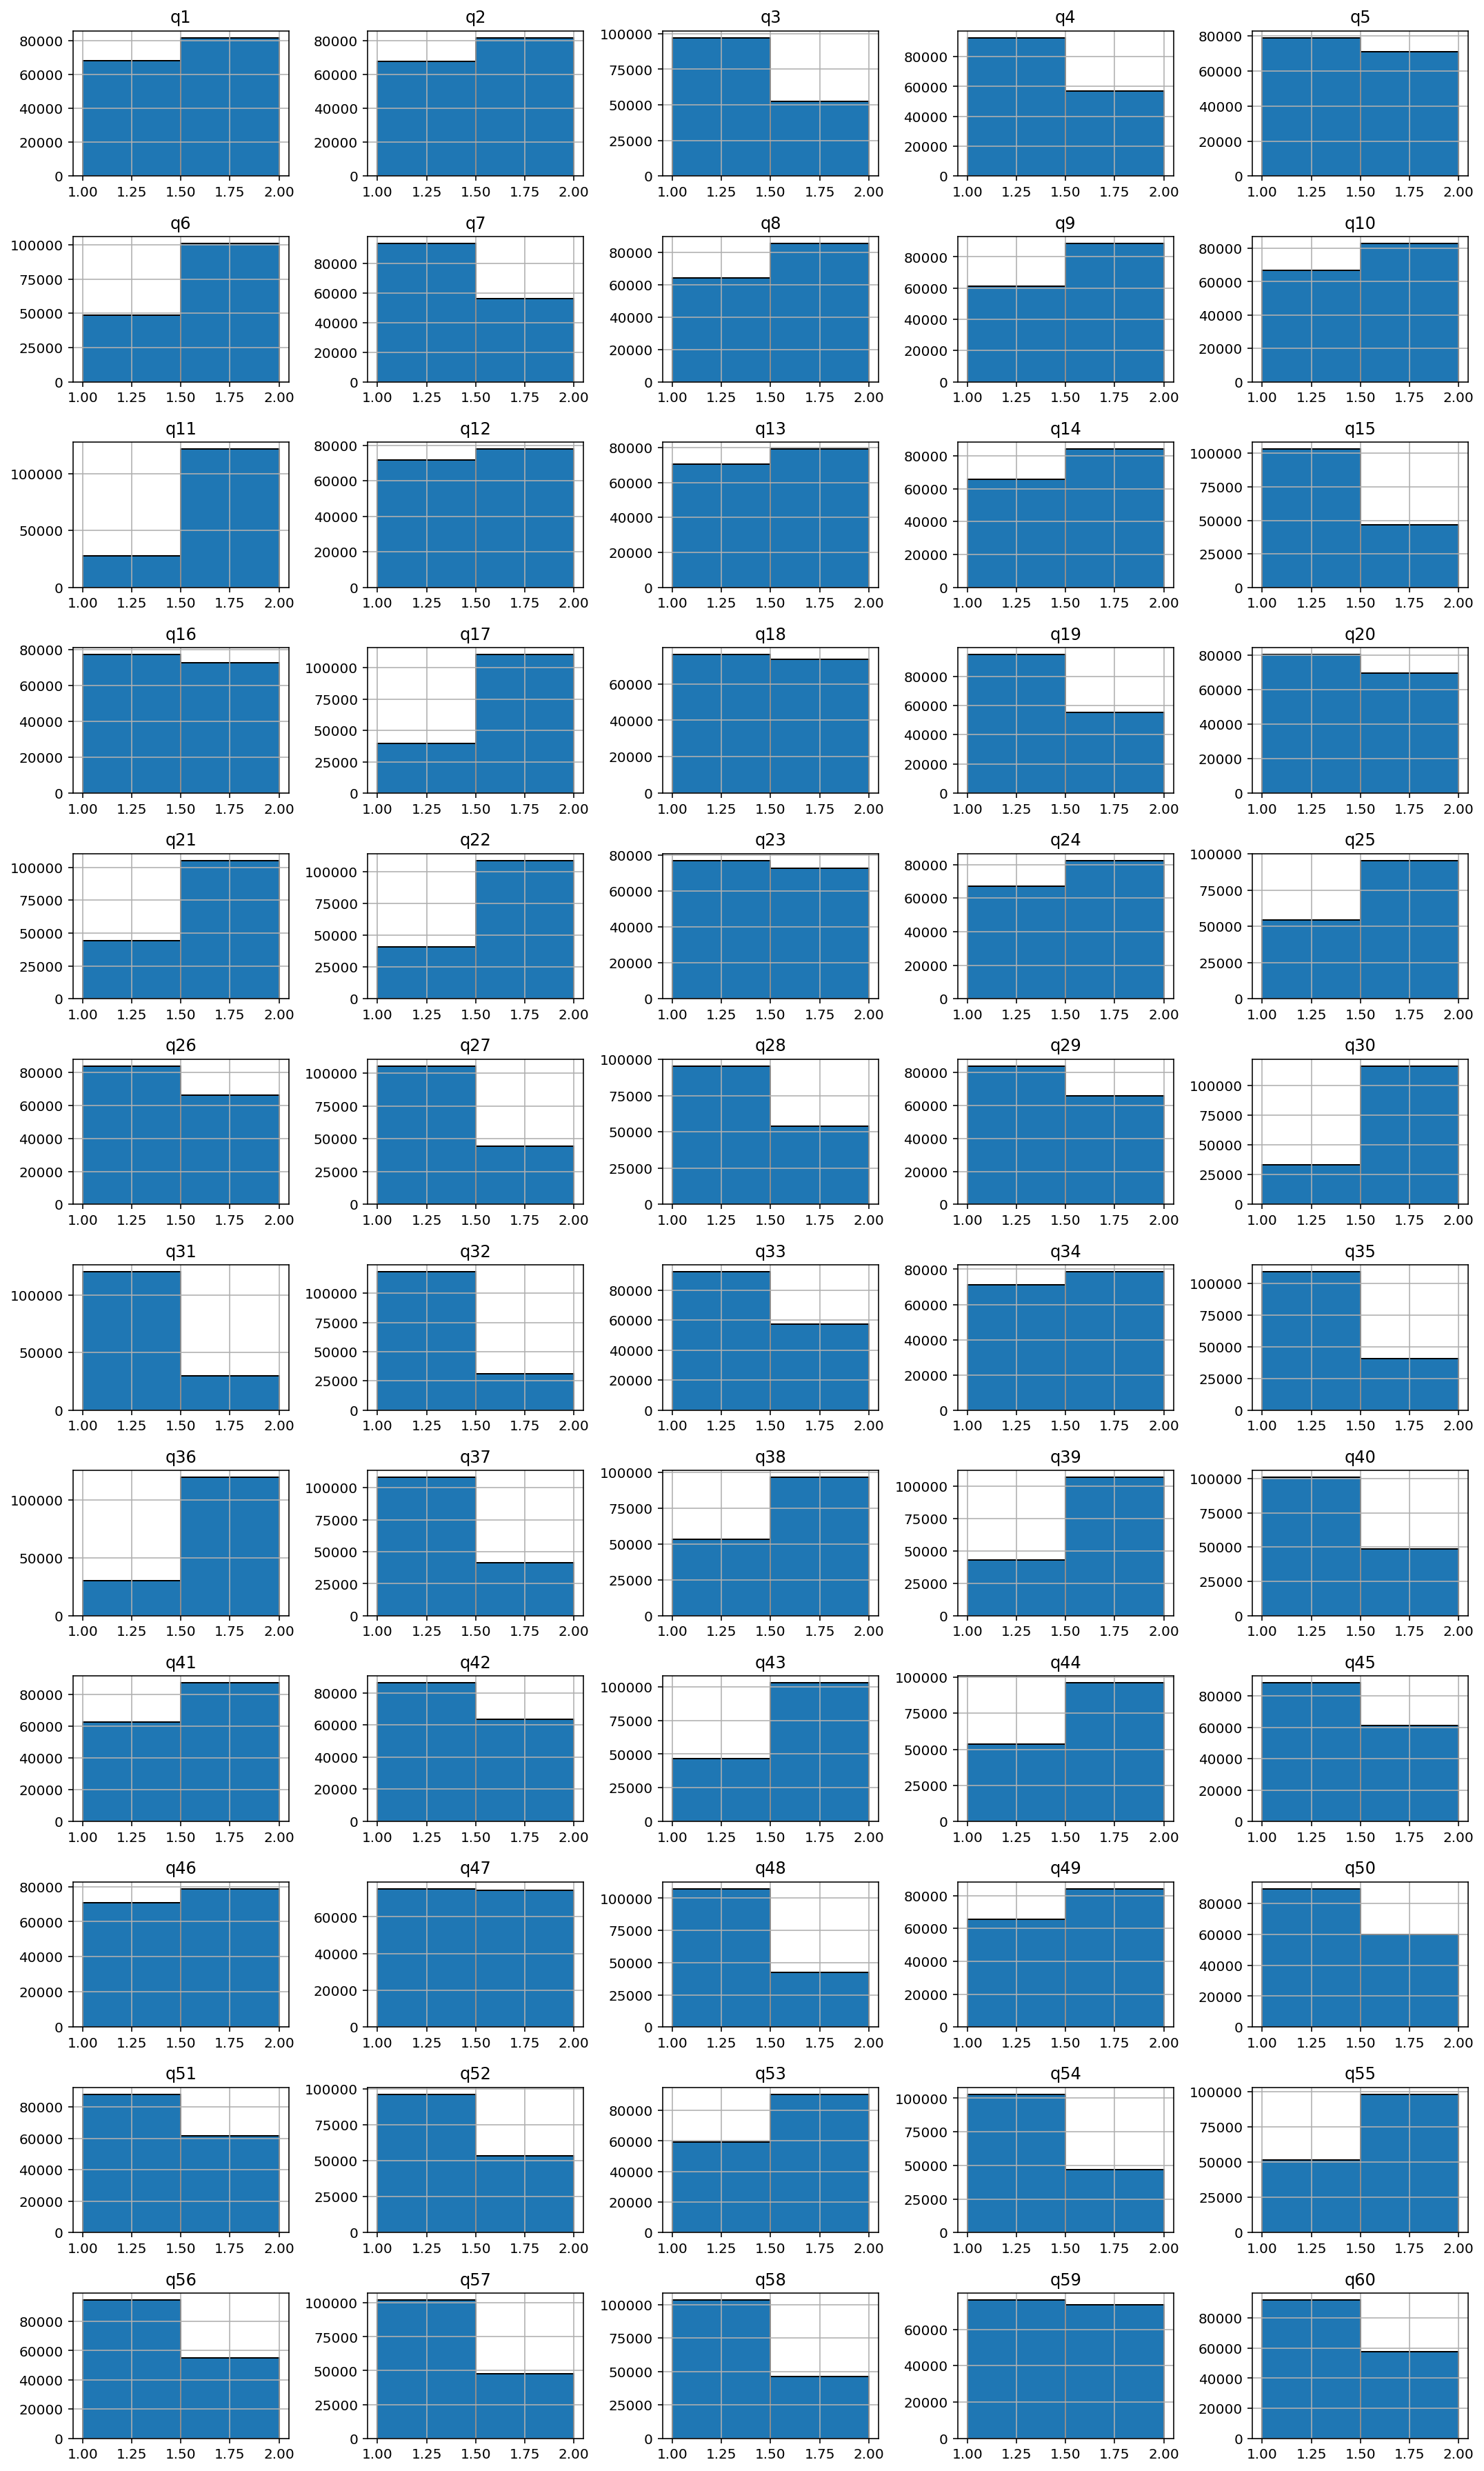

In [41]:
df[psychotype_questions].hist(bins=2, figsize=(15, 25), layout=(-1, 5), edgecolor='black')
plt.tight_layout();

У части признаков наблюдаем дисбаланс ответов. 

#### Время ответа на вопрос

Построим гистограммы для строк до 136206, после которой время имеет одинаковое значение.

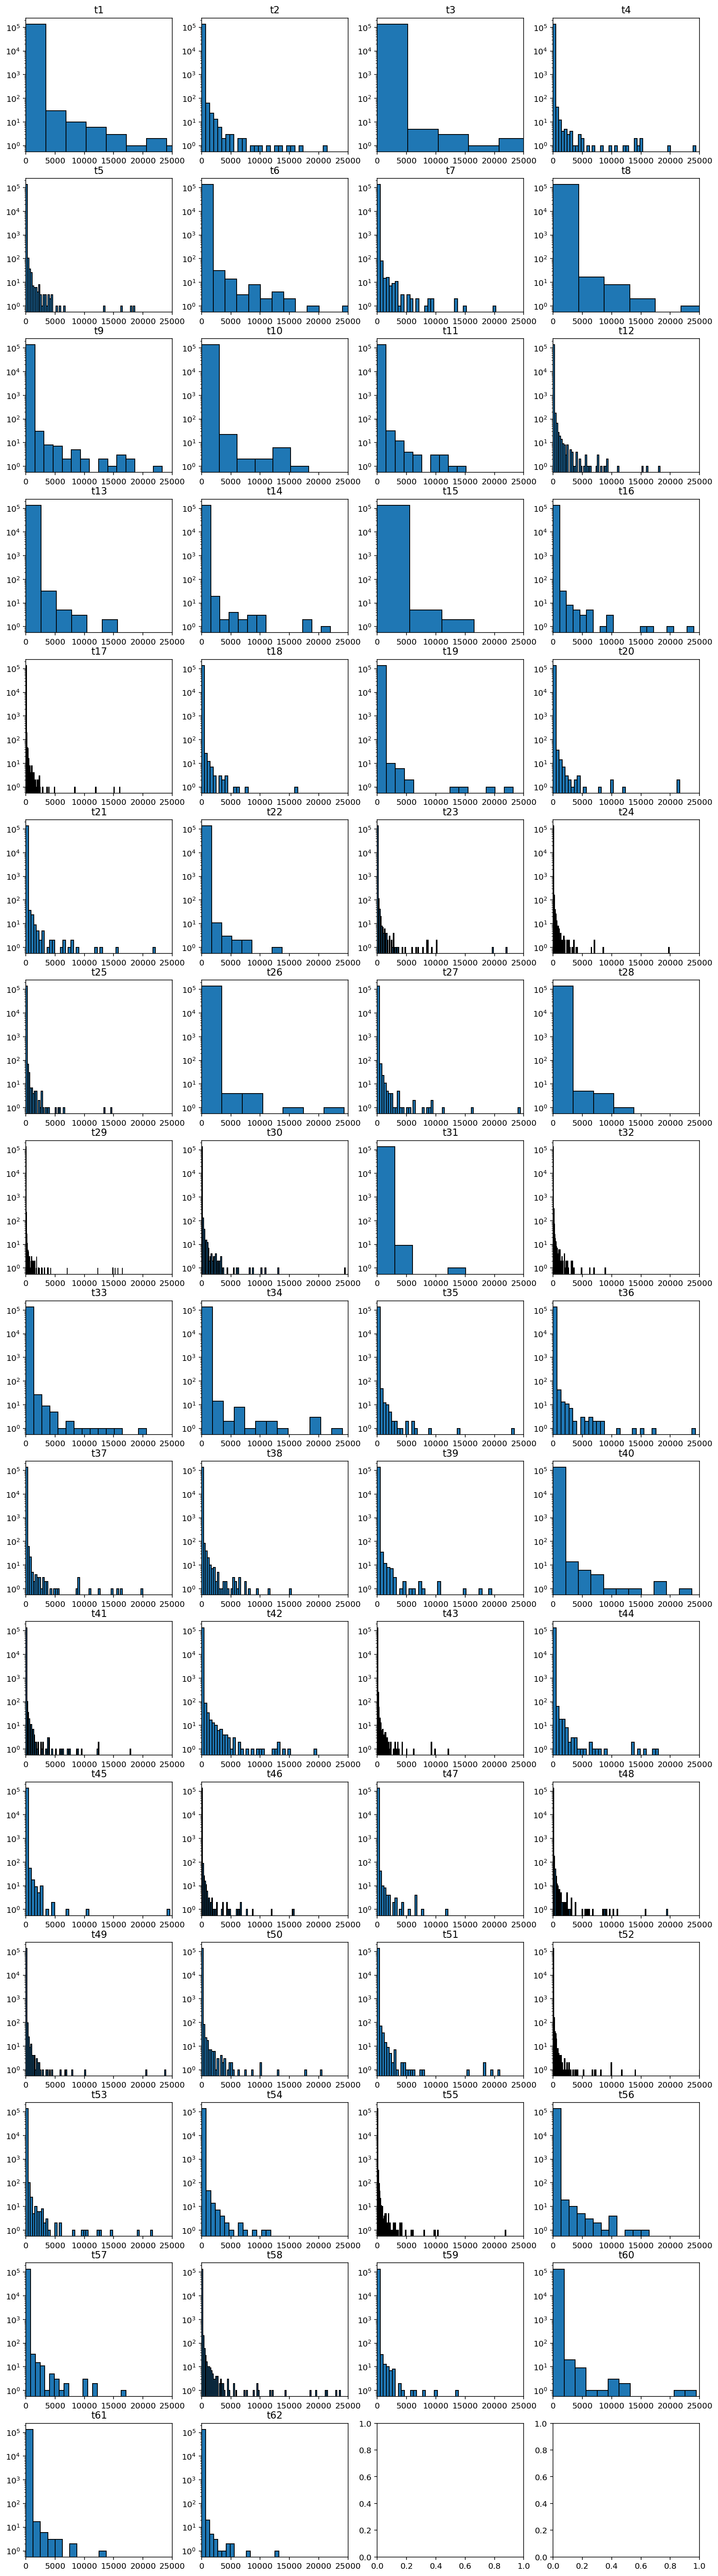

In [43]:
plot_histograms(data = df[times].iloc[:136206],
                n_cols = 4,
                bins = 500,
                log = True,
                xlim = (0,25000))
plt.show()

Видим, что характер распределения для всех признаков одинаковый, но диапазоны значений отличаются. Построим боксплоты, чтобы визуально оценить разницу в статистиках.

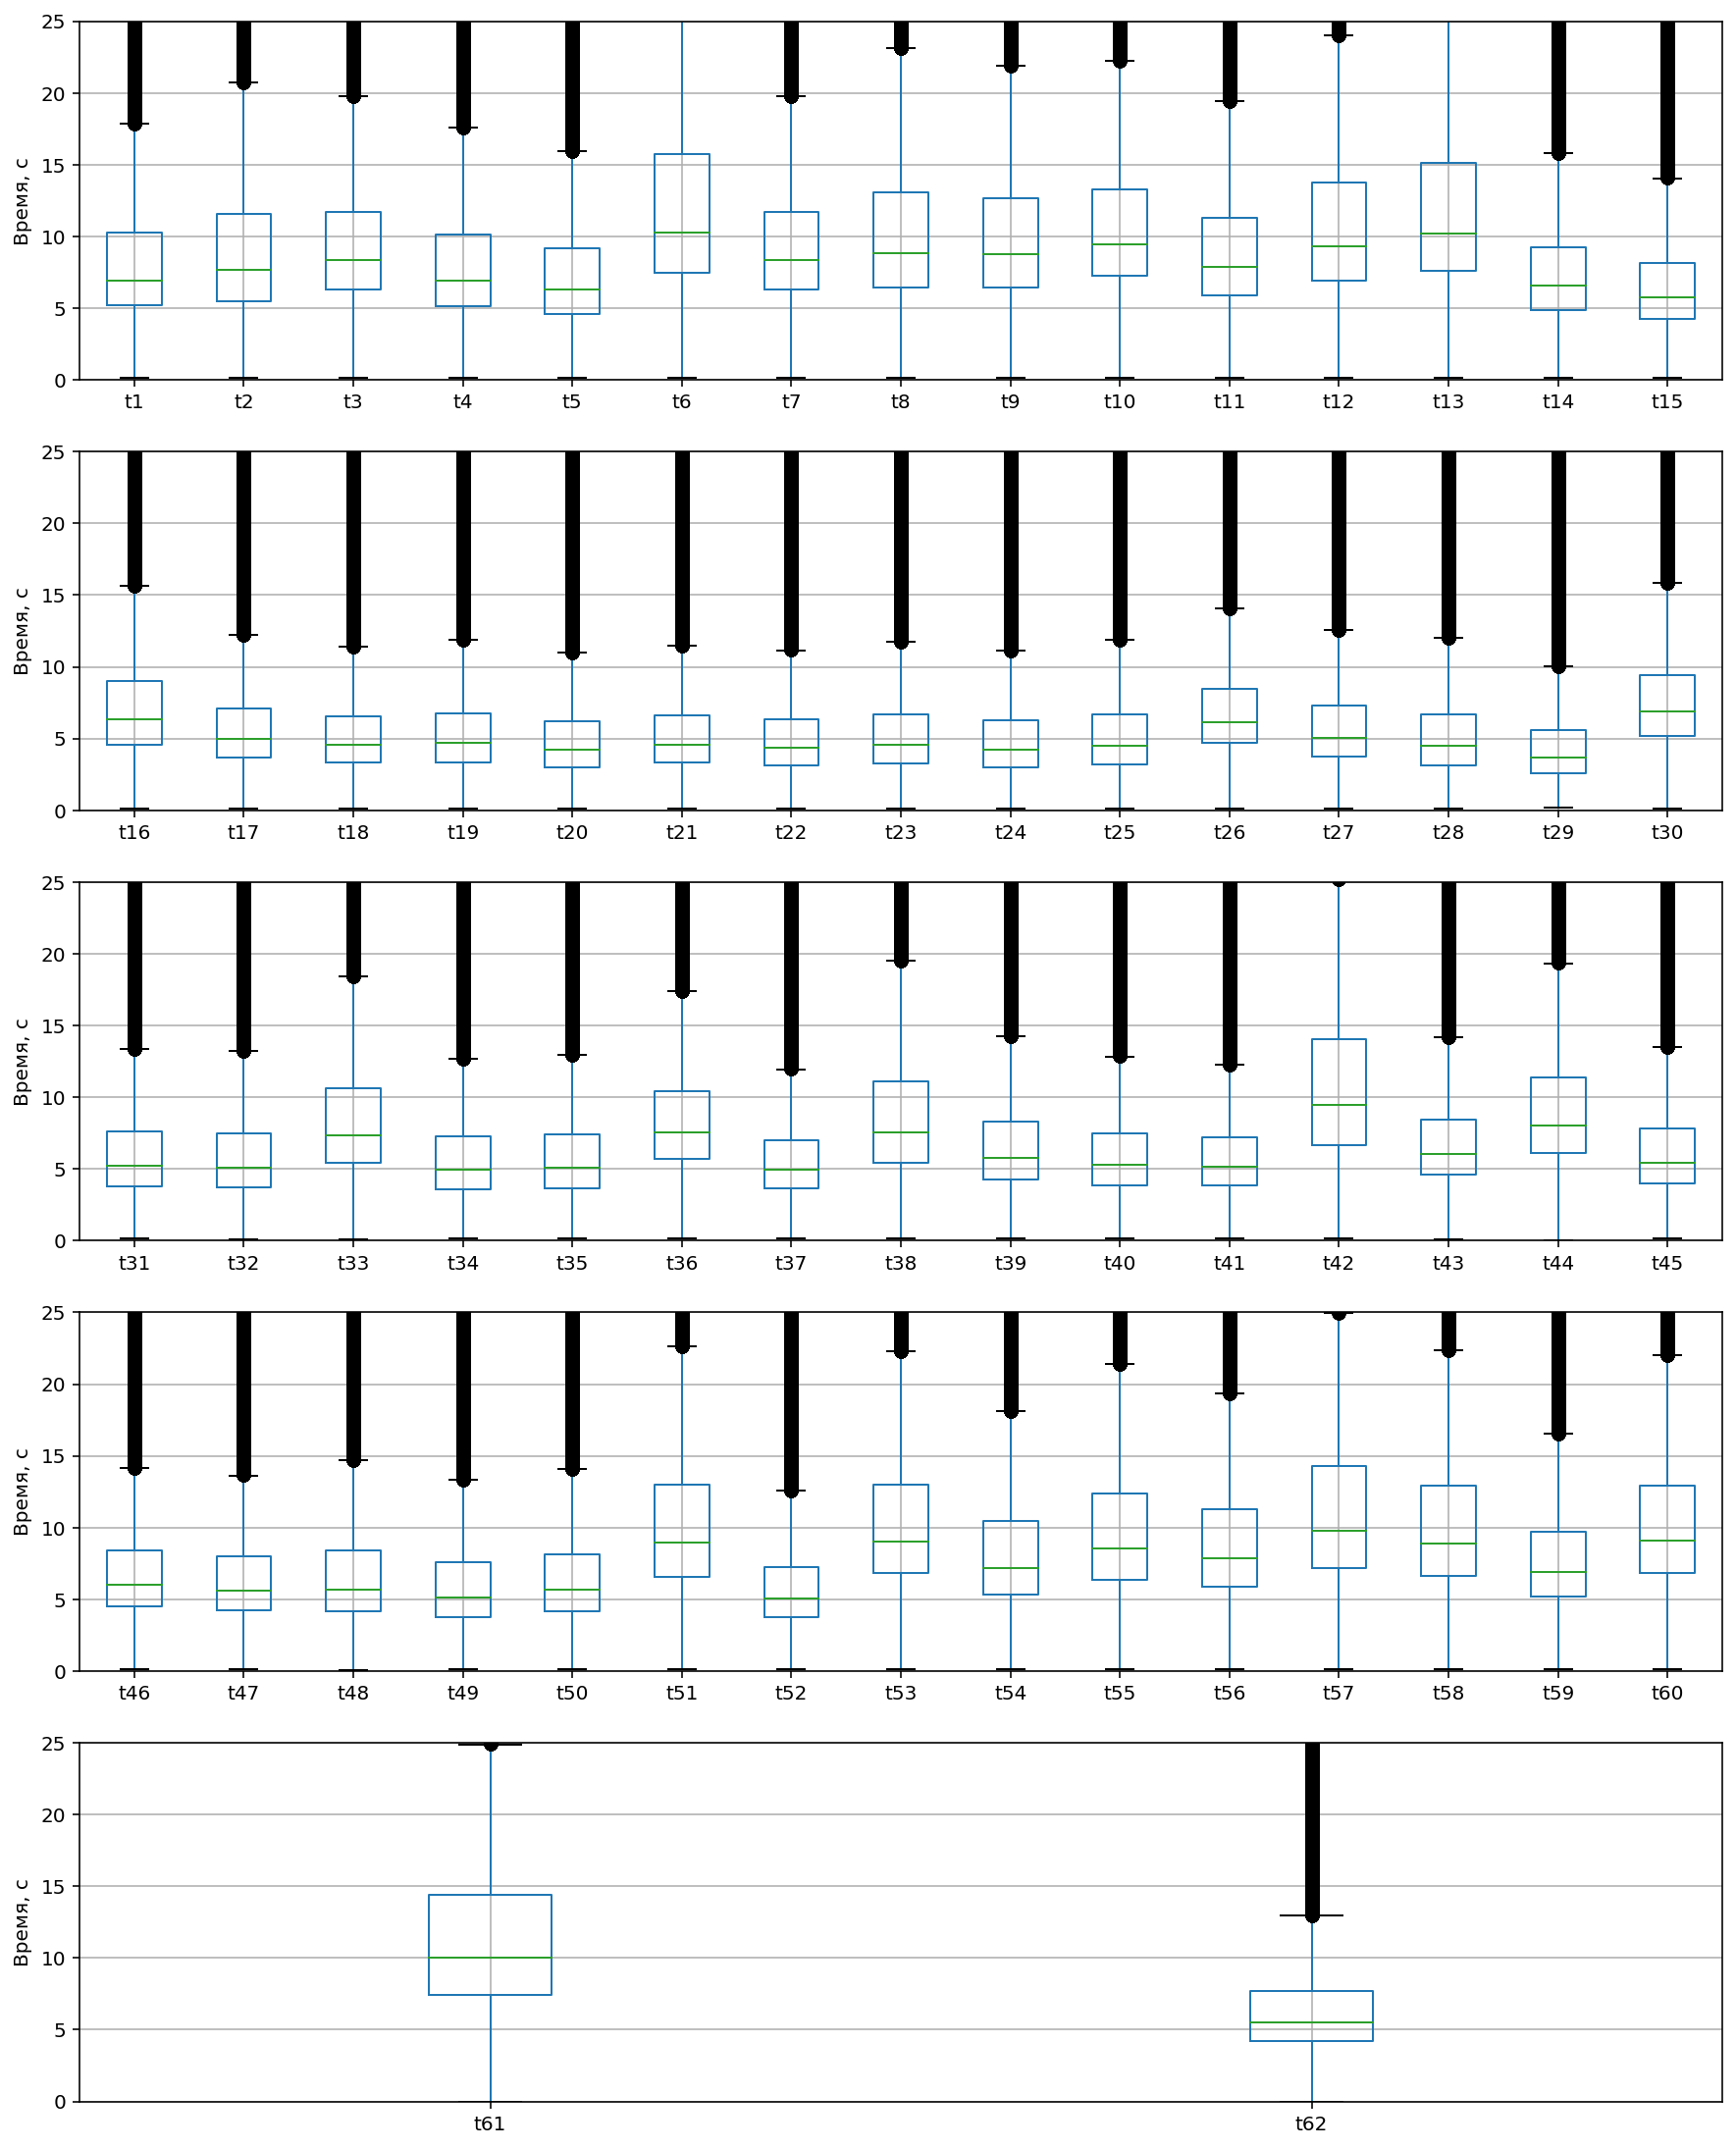

In [44]:
plot_boxpolts(partition = 15, 
              data = df.iloc[:136206], 
              columns = times,
              ylim = (0, 25),
              ylabel = 'Время, с'
             )

Видим, что есть "легкие" вопросы, на которые ответ дается 5-6 секунд, и есть вопросы посложнее, где медиана времени ответа близка к 10 секундам.

Также видим, что ответы со временем больше 25 секунд находятся в области выбросов для всех признаков. 

Время меньше 2.7 секунд находится в первом квартиле для всех признаков. Минимальное значение первого квартиля у t29 и составляет 2.71.

#### Шкалы психотипа

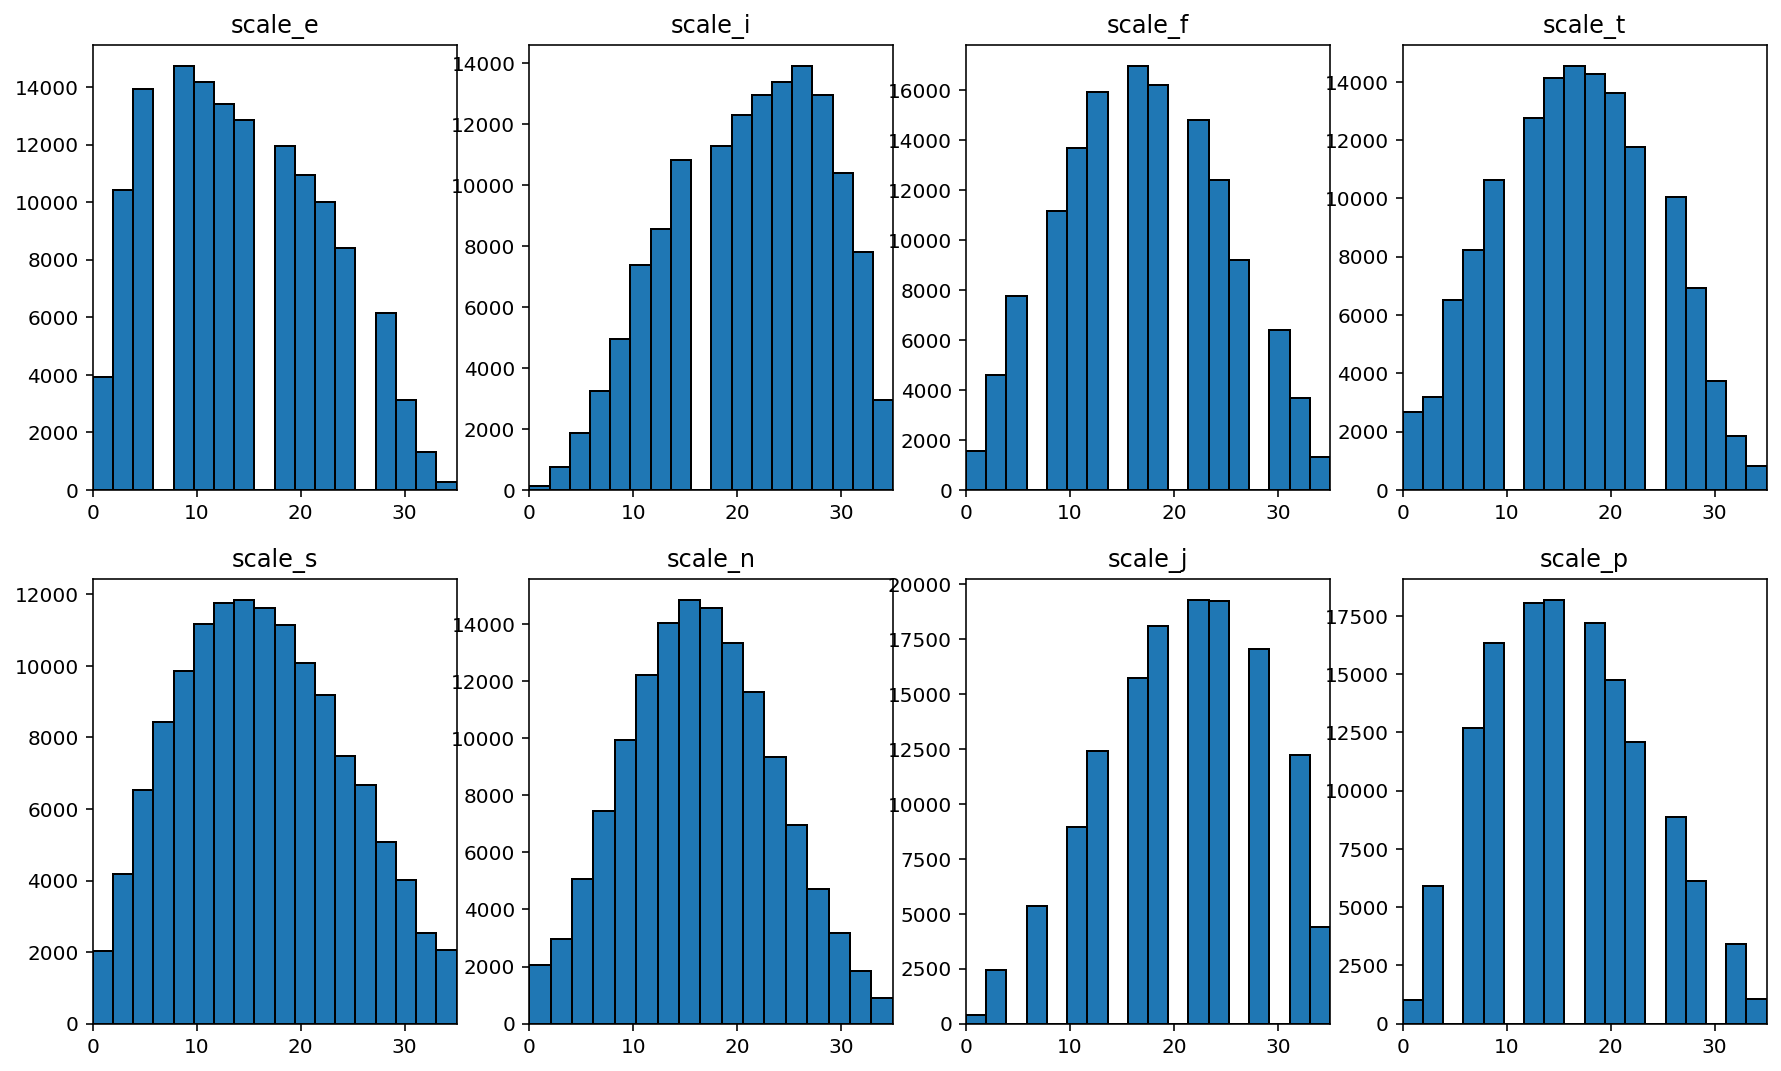

In [54]:
plot_histograms(data = df[scales],
                n_cols = 4,
                bins = 18,
                log = False,
                xlim = (0,35))
plt.show()

#### Ответы "Кем ты работаешь"

In [51]:
STOP_WORDS = nltk.corpus.stopwords.words('russian')

In [64]:
answers = df.q61.apply(clean_sentence)

In [62]:
answers.head()

0                экономист
1    данный момент работаю
2                  учитель
3                    никем
4                 школьник
Name: q61, dtype: object

In [66]:
corpus = build_corpus(answers)

In [131]:
model = Word2Vec(corpus, vector_size=100, window=20, min_count=100, workers=4)

In [135]:
x_vals, y_vals, labels = reduce_dimensions(model)

len(labels)

/Users/dkharitonov/opt/anaconda3/envs/praktikum/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Users/dkharitonov/opt/anaconda3/envs/praktikum/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


235

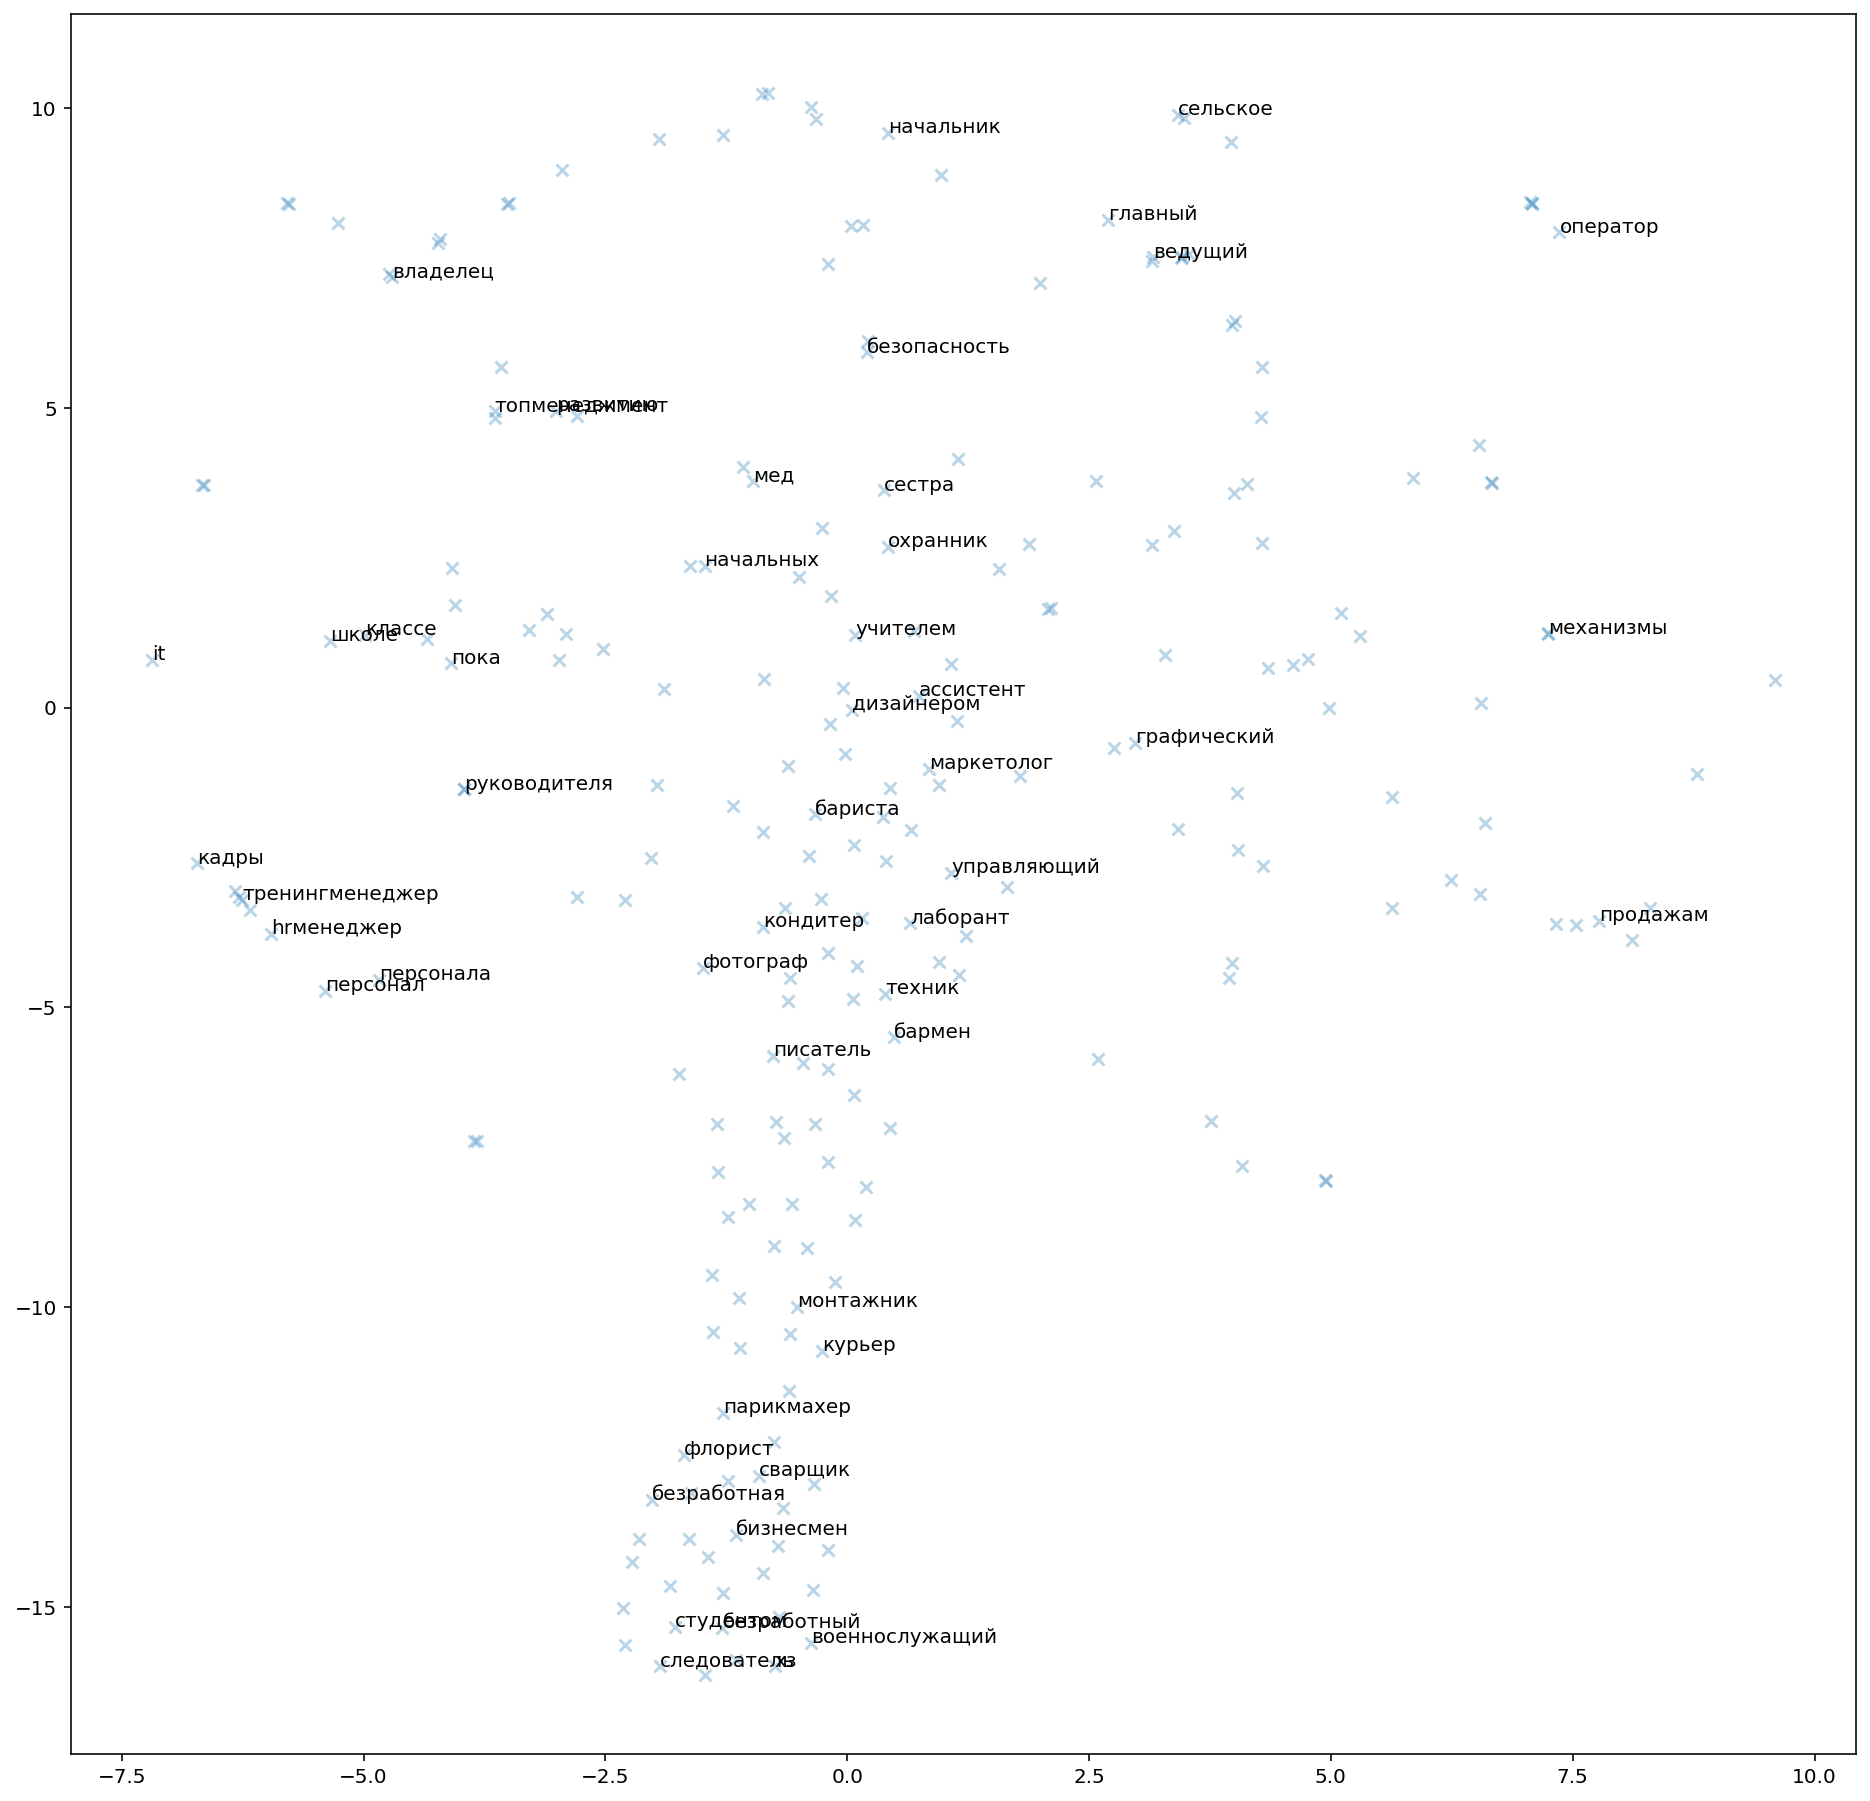

In [136]:
plt.figure(figsize=(16, 16))
plot_words(x_vals, y_vals, labels, 50)
plt.show()

In [123]:
model_sm = Word2Vec(corpus, vector_size=100, window=20, min_count=5, workers=4)

In [124]:
x_vals, y_vals, labels = reduce_dimensions(model_sm)
len(x_vals)

/Users/dkharitonov/opt/anaconda3/envs/praktikum/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Users/dkharitonov/opt/anaconda3/envs/praktikum/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


1768

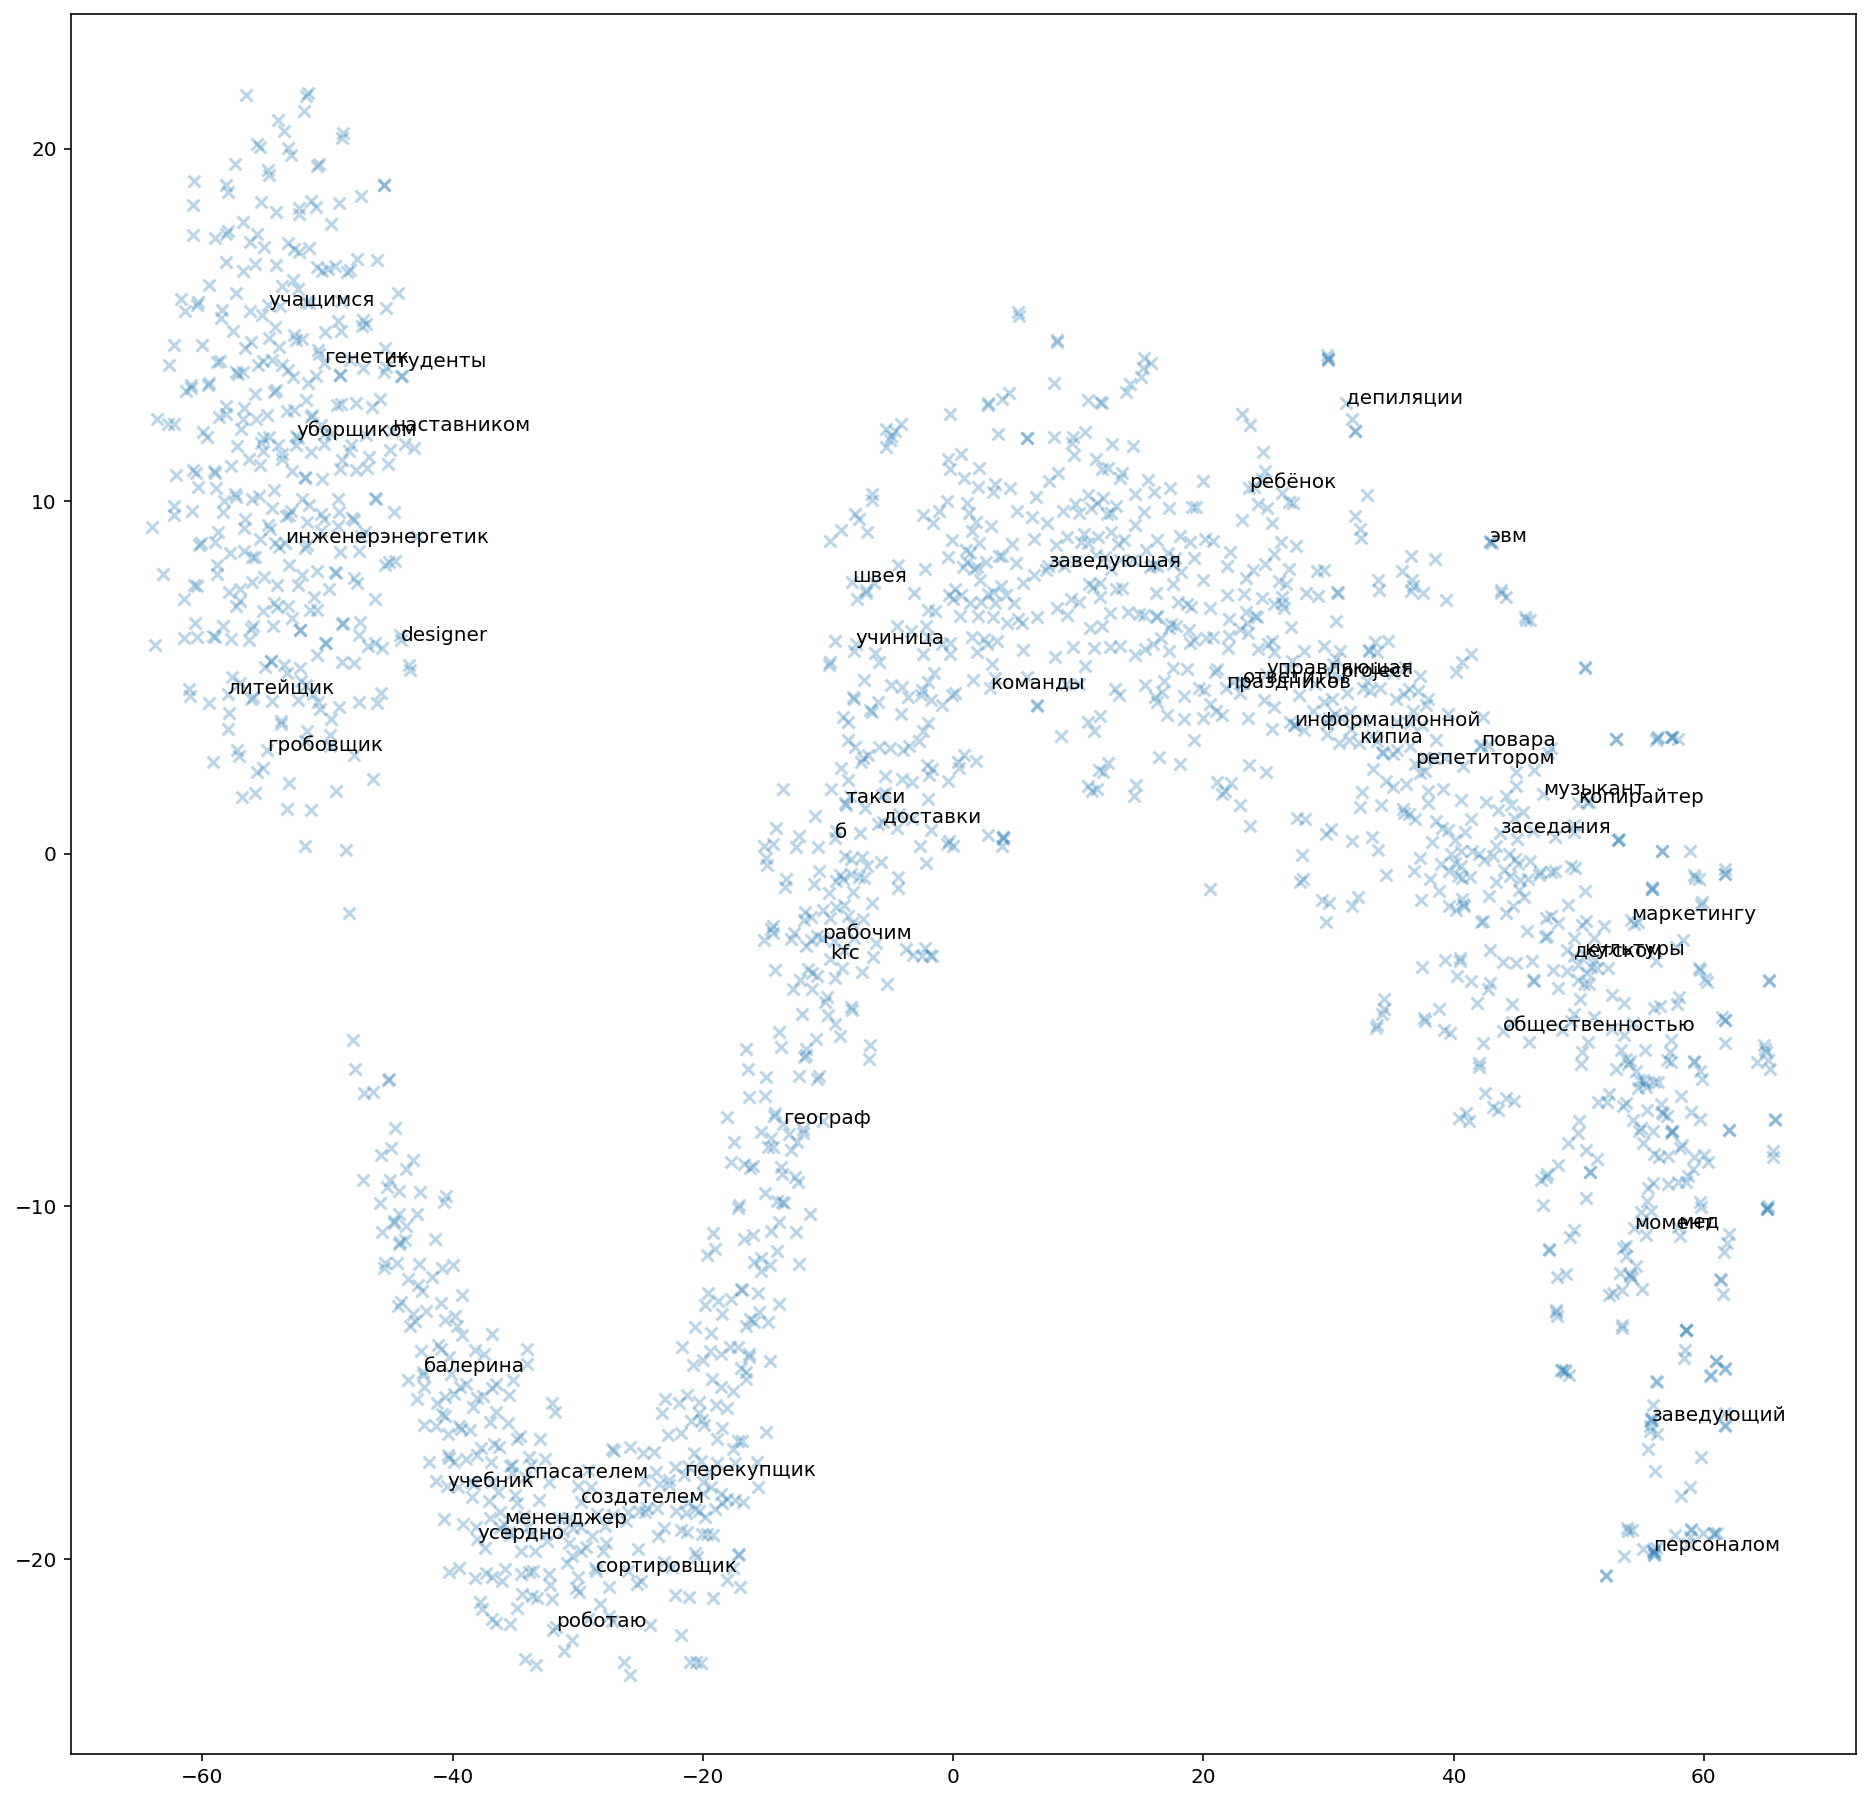

In [125]:
plt.figure(figsize=(16, 16))
plot_words(x_vals, y_vals, labels, 50)
plt.show()

In [137]:
answers.value_counts().head(20)

никем                21771
учусь                 6049
студент               5972
школьник              4775
ученик                4192
кем                   3186
работаю               2773
менеджер              2129
учусь школе           1880
бухгалтер             1806
продавец              1665
учитель               1597
юрист                 1578
инженер               1480
школьником            1474
учащиеся  студент     1427
                      1382
дизайнер              1157
врач                  1088
программист           1073
Name: q61, dtype: int64

### Вывод

TBD 